# 🌍 Background & Introduction — Turbomachinery, Reliability, and APM 🛠️⚙️

![alt text](Turbofan-operation-lbp-1.png)

Turbomachinery (e.g., **gas turbines, compressors, steam turbines, pumps, and turboexpanders**) is at the heart of modern energy and process industries. I chose the **turbofan Remaining Useful Life (RUL)** problem because it strongly matches my interest in **rotating equipment and turbomachines**, where performance, safety, and availability depend heavily on the health of complex components operating under harsh conditions (high temperature, high speed, vibration, and fatigue) 🔥🌀.

## ⚙️ Why turbomachinery maintenance matters
In rotating equipment, small degradations can escalate quickly into major failures. The consequences are often expensive and high-stakes:
- **Safety risk** (catastrophic mechanical failure, secondary damage) 🛡️
- **High downtime cost** (lost production, delayed operations) ⏱️💸
- **Repair and replacement cost** (major overhaul, parts, logistics) 💰
- **Operational reliability and availability** (meeting demand, stable output) ✅

Because of this, turbomachinery industries rely on structured maintenance and reliability practices such as:
- Condition monitoring (vibration, temperature, pressure, performance trends) 📈
- Reliability modeling and risk forecasting 🎯
- Planned interventions before failure (CBM / predictive maintenance) 🔧

## 🧠 Asset Performance Management (APM) in turbomachinery
**APM** is the practical bridge between monitoring data and maintenance action. The goal is not just to predict failure, but to **optimize decisions**:
- **Detect degradation early** (health indicators) 🔍
- **Predict remaining useful life (RUL)** to plan interventions 📆
- **Balance cost vs. risk** by choosing when to inspect and when to do planned maintenance 💰⚖️
- **Improve fleet availability and reliability** while respecting safety constraints 🏭🛡️

## 📌 Project objective (what this notebook delivers)
This project uses the NASA C-MAPSS FD001 turbofan dataset as a realistic turbomachinery degradation case study. The notebook builds:
1) **Reliability modeling (ISE-506)**: fleet-level survival/reliability behavior and age-based risk forecasting 📉  
2) **CBM/APM optimization (ISE-510)**: a health index + RUL learning pipeline and a cost-optimized maintenance policy under safety constraints ⚙️💵  

🎯 **Final goal:** demonstrate a complete workflow from **data → health/risk → decision policy → cost & safety impact**, aligned with real-world turbomachinery maintenance thinking ✅🌀


## 📦 Imports & Libraries Setup

This cell imports all required libraries for the project:
- **Data handling:** `numpy`, `pandas`
- **Visualization:** `matplotlib`
- **Machine Learning (scikit-learn):** scaling, error metrics, `GroupKFold`, Ridge regression, PCA
- **Deep Learning (PyTorch):** model building, datasets, dataloaders
- **Reliability & statistics:** Weibull distribution and gamma functions
- **Utilities & display:** OS utilities, random seed control, and notebook display helpers

✅ After this cell, the notebook is ready for **reliability modeling (ISE-506)** and **APM/CBM + deep RUL modeling (ISE-510)**.


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GroupKFold 

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from scipy.stats import weibull_min

from math import gamma

from scipy.special import gamma as Gamma, gammainc

from IPython.display import display, HTML

from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge

import os, random

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.linear_model import RidgeCV

## 🗂️ C-MAPSS Data Loader (FD001 Only for Simplicity)

The NASA C-MAPSS turbofan dataset includes multiple operating conditions and fault modes (**FD001–FD004**), which makes the full dataset relatively large and repetitive to process during this project.

✅ To keep the analysis **focused**, **avoid redundant work**, and simplify interpretation, this notebook uses **FD001 only**.

**What this cell does**
- Defines the **21 sensor names** and builds the correct column structure:
  - `engine_id`, `cycle`, `op_setting_1..3`, plus all sensor columns
- Loads FD001 files from GitHub:
  - `train_FD001` (run-to-failure trajectories)
  - `test_FD001` (partial trajectories, not run-to-failure)
  - `rul_FD001` (true RUL at the **last observed cycle** for each test engine)
- Adds **RUL labels**:
  - **TRAIN:** `RUL = max_cycle(engine) − cycle`
  - **TEST:** `RUL = (last_cycle + RUL_last) − cycle`
- Runs basic checks and shows previews ✅

📌 **Outputs created:** `train_FD001`, `test_FD001`, `rul_FD001`

In [12]:
# =========================================================================#
# C-MAPSS (NASA Turbofan) — FD001 ONLY loader (NO PLOTS)                   #
# Loads: train_FD001, test_FD001, rul_FD001 with proper column names + RUL #
# =========================================================================#

BASE = "https://raw.githubusercontent.com/Tareq-Alsahaf/ISE-518/main/Data-CMaps"

SENSOR_NAMES = [
    "(Fan inlet temperature) (◦R)",
    "(LPC outlet temperature) (◦R)",
    "(HPC outlet temperature) (◦R)",
    "(LPT outlet temperature) (◦R)",
    "(Fan inlet Pressure) (psia)",
    "(bypass-duct pressure) (psia)",
    "(HPC outlet pressure) (psia)",
    "(Physical fan speed) (rpm)",
    "(Physical core speed) (rpm)",
    "(Engine pressure ratio (P50/P2))",
    "(HPC outlet Static pressure) (psia)",
    "(Ratio of fuel flow to Ps30) (pps/psia)",
    "(Corrected fan speed) (rpm)",
    "(Corrected core speed) (rpm)",
    "(Bypass Ratio)",
    "(Burner fuel-air ratio)",
    "(Bleed Enthalpy)",
    "(Required fan speed)",
    "(Required fan conversion speed)",
    "(High-pressure turbines Cool air flow)",
    "(Low-pressure turbines Cool air flow)",
]

def _make_cmaps_columns(n_cols: int):
    """
    C-MAPSS layout:
      2 id columns + 3 operational settings + N sensor columns (usually N=21)
    """
    if n_cols < 6:
        raise ValueError(f"Unexpected number of columns ({n_cols}). Expected at least 6.")
    n_sensors = n_cols - 5

    if n_sensors != len(SENSOR_NAMES):
        raise ValueError(
            f"Expected {len(SENSOR_NAMES)} sensors, but file has {n_sensors} sensor columns "
            f"(total columns={n_cols})."
        )

    cols = ["engine_id", "cycle", "op_setting_1", "op_setting_2", "op_setting_3"]
    cols += SENSOR_NAMES
    return cols

def _add_rul_train(train: pd.DataFrame) -> pd.DataFrame:
    """Train is run-to-failure => RUL = max(cycle per engine) - cycle."""
    df = train.copy()
    df["RUL"] = df.groupby("engine_id")["cycle"].transform("max") - df["cycle"]
    return df

def _add_rul_test(test: pd.DataFrame, rul_last_df: pd.DataFrame) -> pd.DataFrame:
    """
    Test does not run to failure.
    RUL file provides RUL at the LAST observed cycle for each engine.
    For each row: RUL = (last_cycle + RUL_last) - cycle
    """
    df = test.copy()

    engine_ids = np.sort(df["engine_id"].unique())
    if len(engine_ids) != len(rul_last_df):
        raise ValueError(
            f"Mismatch: test has {len(engine_ids)} engines, but RUL file has {len(rul_last_df)} rows."
        )

    rul_map = pd.DataFrame({
        "engine_id": engine_ids,
        "RUL_last": rul_last_df["RUL"].to_numpy()
    })

    last_cycle = df.groupby("engine_id")["cycle"].max().reset_index(name="last_cycle")
    df = df.merge(last_cycle, on="engine_id", how="left").merge(rul_map, on="engine_id", how="left")

    df["RUL"] = (df["last_cycle"] + df["RUL_last"]) - df["cycle"]

    return df.drop(columns=["last_cycle", "RUL_last"])

def load_cmaps(fd: str):
    fd = fd.upper().replace(".TXT", "")
    if not fd.startswith("FD"):
        fd = f"FD{fd.zfill(3)}"  # e.g., "1" -> "FD001"

    train_url = f"{BASE}/Training/train_{fd}.txt"
    test_url  = f"{BASE}/Testing/test_{fd}.txt"
    rul_url   = f"{BASE}/Results%20(RUL)/RUL_{fd}.txt"

    train = pd.read_csv(train_url, sep=r"\s+", header=None).dropna(axis=1, how="all")
    test  = pd.read_csv(test_url,  sep=r"\s+", header=None).dropna(axis=1, how="all")
    rul   = pd.read_csv(rul_url,   sep=r"\s+", header=None).dropna(axis=1, how="all")

    train.columns = _make_cmaps_columns(train.shape[1])
    test.columns  = _make_cmaps_columns(test.shape[1])

    if rul.shape[1] != 1:
        raise ValueError(f"{fd} RUL file should have 1 column, but has {rul.shape[1]}.")
    rul.columns = ["RUL"]

    train["FD"] = fd
    test["FD"]  = fd
    rul["FD"]   = fd

    train = _add_rul_train(train)
    test  = _add_rul_test(test, rul)

    return train, test, rul

# ============================================================
# Load FD001 only
# ============================================================
train_FD001, test_FD001, rul_FD001 = load_cmaps("FD001")

# Verify + preview
print(f"FD001 shapes -> train: {train_FD001.shape} | test: {test_FD001.shape} | rul: {rul_FD001.shape}")
print(f"FD001 train RUL [min, max]: [{train_FD001['RUL'].min()} , {train_FD001['RUL'].max()}]")
print(f"FD001 test  RUL [min, max]: [{test_FD001['RUL'].min()} , {test_FD001['RUL'].max()}]")

display(train_FD001.head())
display(test_FD001.head())
display(rul_FD001.head())

FD001 shapes -> train: (20631, 28) | test: (13096, 28) | rul: (100, 2)
FD001 train RUL [min, max]: [0 , 361]
FD001 test  RUL [min, max]: [7 , 340]


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),FD,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,FD001,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,FD001,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,FD001,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,FD001,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,FD001,187


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),FD,RUL
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,FD001,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,FD001,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,FD001,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,FD001,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,FD001,138


,RUL,FD
0,112,FD001
1,98,FD001
2,69,FD001
3,82,FD001
4,91,FD001


# ✅ FD001 Data Quality Check (Missing Values + Duplicates)

This cell performs a quick **data quality audit** for the FD001 dataset components:
- **TRAIN**
- **TEST**
- **RUL (ground-truth last-cycle RUL)**

**What it checks**
- 🔍 **Missing values:** total number of `NaN` entries in each dataset  
- 🧾 **Duplicate rows:** total duplicated records (if any)  
- 📐 Also reports dataset size (**rows × columns**) for transparency

**Extra robustness**
- If `train_FD001`, `test_FD001`, or `rul_FD001` are not defined yet, the cell automatically loads FD001 using `load_cmaps("FD001")` ✅

📌 **Why this matters:** clean and consistent input data improves reliability modeling (ISE-506) and health/maintenance optimization (ISE-510).


In [13]:
# =========================
# FD001 Data Quality Check (TRAIN / TEST / RUL)
#   - Missing values + duplicate rows
#   - Compatible with your variables: train_FD001, test_FD001, rul_FD001
# =========================

rows = []
for name, df in [("FD001-TRAIN", train_FD001), ("FD001-TEST", test_FD001), ("FD001-RUL", rul_FD001)]:
    missing = int(df.isna().sum().sum())
    duplicates = int(df.duplicated().sum())
    rows.append([name, missing, duplicates])

report_fd001 = pd.DataFrame(rows, columns=["Dataset", "Missing_Values", "Duplicate_Rows"])
display(report_fd001)


,Dataset,Missing_Values,Duplicate_Rows
0,FD001-TRAIN,0,0
1,FD001-TEST,0,0
2,FD001-RUL,0,29


# 🚨 FD001 Outlier Screening (IQR, TRAIN-Calibrated)

This cell checks FD001 sensors for **extreme outliers** using a conservative **IQR rule** (fit on **TRAIN only** to avoid leakage) 🛡️✅  
It reports, for **TRAIN** and **TEST**:
- total flagged outlier cells
- number/percentage of rows with ≥1 outlier
- top sensors contributing most flags 🏅📊

⚠️ **Important note:** Outliers are **kept** (not removed). In turbomachinery, spikes and unusual readings can represent **real operating events, degradation, or abnormal conditions**, so removing them may hide valuable failure-related behavior 🌀🔧


In [14]:
# =========================
# FD001 Outlier Screening (IQR-based, TRAIN-fitted bounds) ✅
#   - Same style/output as your multi-FD version, but FD001 only
#   - Fits IQR bounds on TRAIN sensors, flags outliers in TRAIN and TEST
# =========================

import numpy as np
import pandas as pd

# Ensure FD001 is loaded
if not all(k in globals() for k in ["train_FD001", "test_FD001"]):
    if "load_cmaps" not in globals():
        raise NameError("FD001 not loaded and load_cmaps() not found. Run the FD001 loader cell first.")
    train_FD001, test_FD001, rul_FD001 = load_cmaps("FD001")
    print("FD001 was not defined -> loaded now using load_cmaps('FD001') ✅")

def get_sensor_cols(df: pd.DataFrame):
    # Your sensor columns are strings that start with "(" because of SENSOR_NAMES
    return [c for c in df.columns if isinstance(c, str) and c.strip().startswith("(")]

def iqr_outlier_report(train_df: pd.DataFrame, target_df: pd.DataFrame, sensor_cols, k=3.0):
    """
    Fit bounds on TRAIN only, then flag outliers in target_df.
    Extreme IQR bounds: Q1 - k*IQR, Q3 + k*IQR  (k=3 is conservative)
    Returns: (#outlier_cells, #rows_with_any_outlier, top_sensors_series)
    """
    q1 = train_df[sensor_cols].quantile(0.25)
    q3 = train_df[sensor_cols].quantile(0.75)
    iqr = (q3 - q1).replace(0, np.nan)

    lower = q1 - k * iqr
    upper = q3 + k * iqr

    mask = target_df[sensor_cols].lt(lower, axis=1) | target_df[sensor_cols].gt(upper, axis=1)
    outlier_cells = int(mask.sum().sum())
    outlier_rows = int(mask.any(axis=1).sum())
    top_sensors = mask.sum().sort_values(ascending=False)
    return outlier_cells, outlier_rows, top_sensors

# Detect sensor columns
sensor_cols = get_sensor_cols(train_FD001)
if not sensor_cols:
    raise ValueError("FD001: No sensor columns detected (expected column names starting with '(').")

# Reports (TRAIN-fitted bounds)
tr_cells, tr_rows, tr_top = iqr_outlier_report(train_FD001, train_FD001, sensor_cols, k=3.0)
te_cells, te_rows, te_top = iqr_outlier_report(train_FD001, test_FD001,  sensor_cols, k=3.0)

rows = []
rows.append(["FD001-TRAIN", tr_cells, tr_rows, tr_rows / len(train_FD001)])
rows.append(["FD001-TEST",  te_cells, te_rows, te_rows / len(test_FD001)])

outlier_summary_fd001 = pd.DataFrame(
    rows,
    columns=["Dataset", "Flagged_Outlier_Cells", "Rows_With_>=1_Flag", "Ratio_Rows_Flagged"]
)
outlier_summary_fd001["Pct_Rows_Flagged_%"] = (outlier_summary_fd001["Ratio_Rows_Flagged"] * 100).round(2)

display(outlier_summary_fd001)

# # Optional: show top sensors driving outlier flags (top 10)
# print("\nTop 10 sensors by outlier flags (FD001-TRAIN):")
# display(tr_top.head(10).rename("Outlier_Flags"))

# print("\nTop 10 sensors by outlier flags (FD001-TEST):")
# display(te_top.head(10).rename("Outlier_Flags"))


,Dataset,Flagged_Outlier_Cells,Rows_With_>=1_Flag,Ratio_Rows_Flagged,Pct_Rows_Flagged_%
0,FD001-TRAIN,1505,819,0.039698,3.97
1,FD001-TEST,75,43,0.003283,0.33


# 📊 FD001 Sensor Distribution Plots (TRAIN + TEST pooled)

This cell visualizes the **raw distribution** of each FD001 sensor using histograms.

**What it does**
- Detects the **FD001 sensor columns** (names starting with `"("`) ✅
- Pools FD001 **TRAIN + TEST** sensor data to represent the full operating range 🧩
- Plots **one histogram per sensor** (≈ 21 figures) 📈
- Uses a fixed number of bins (`BINS`) for consistent visualization
- Adds a dashed vertical line showing the **mean** sensor value 🎯

⚠️ **Note:** Distributions are shown in **raw units (no scaling)** to understand natural variability before building HI/RUL models.


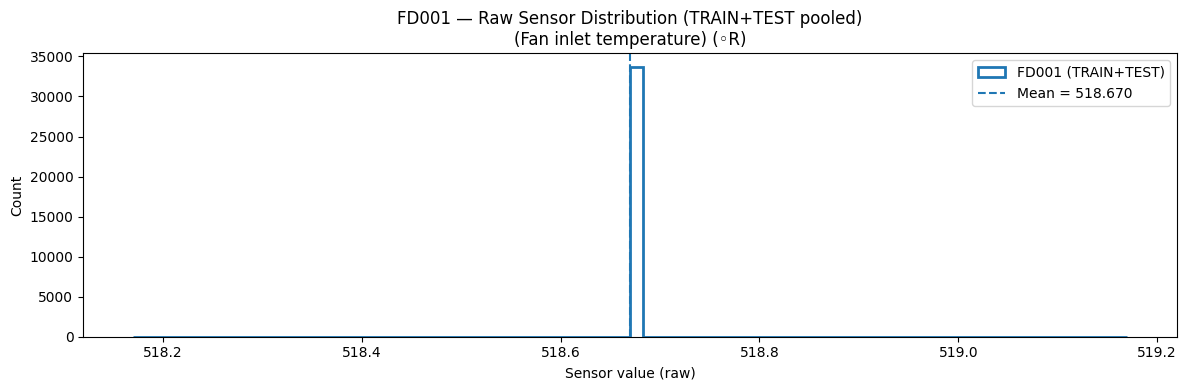

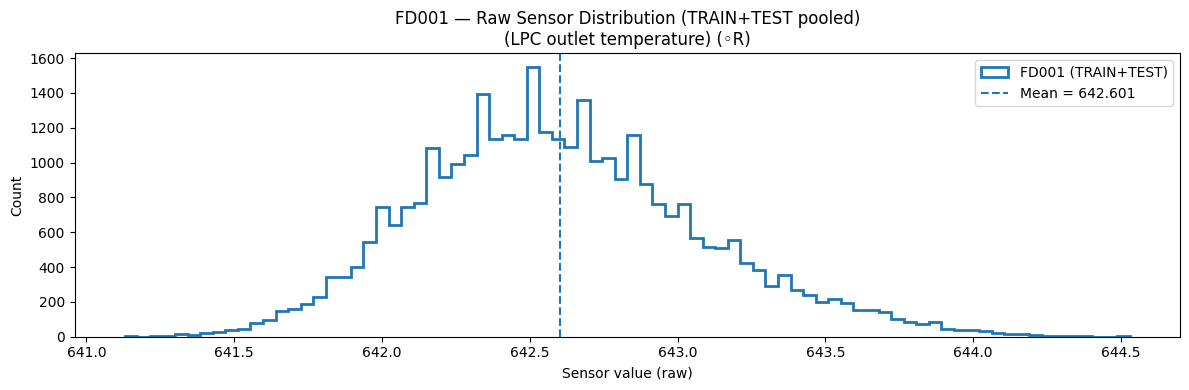

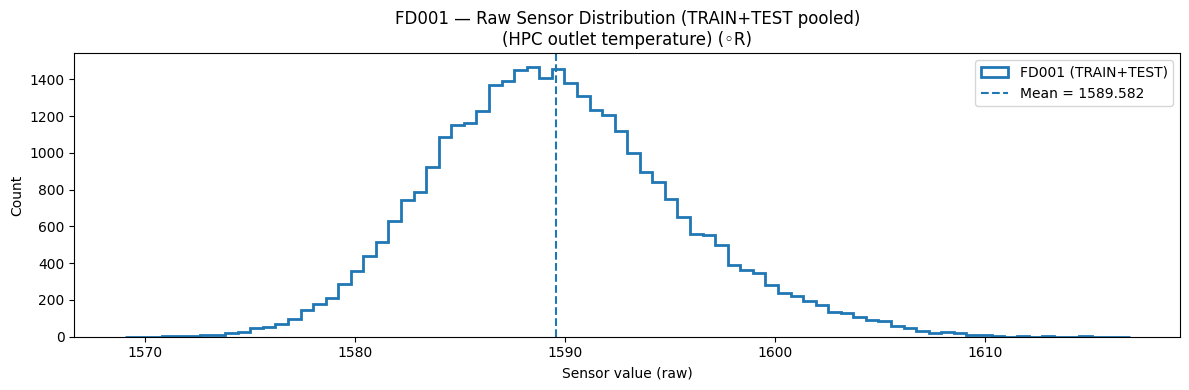

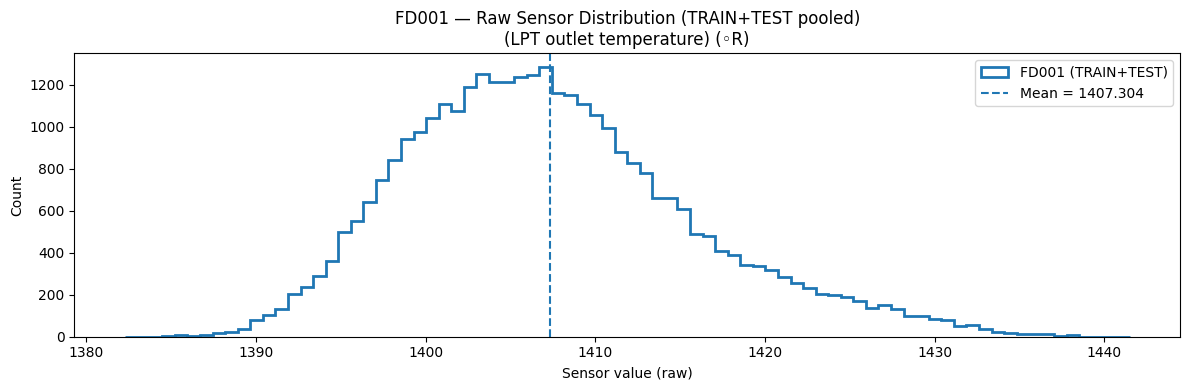

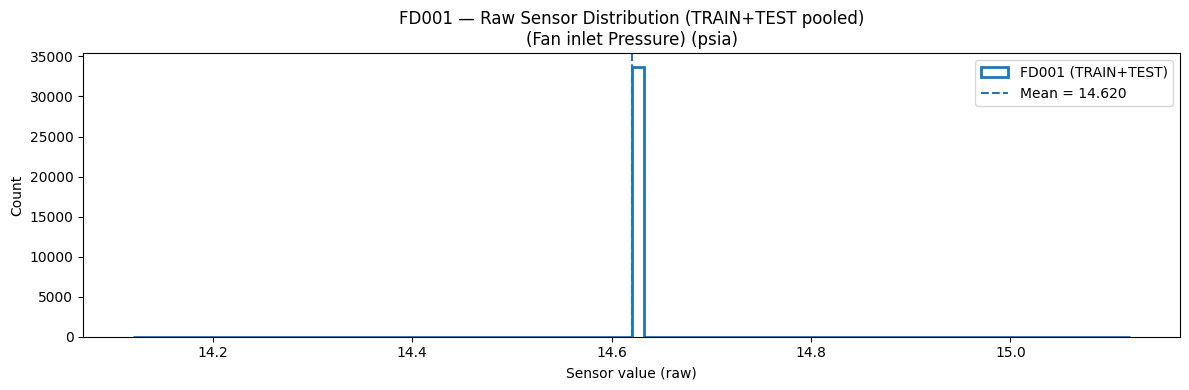

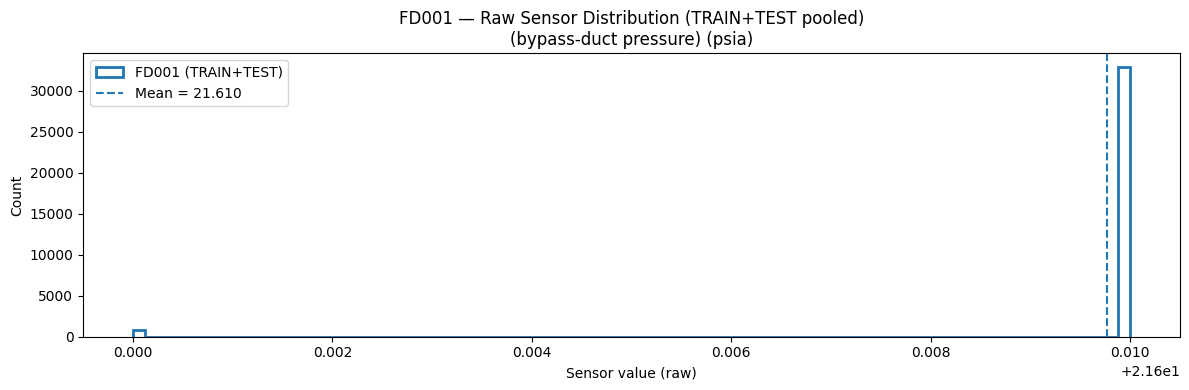

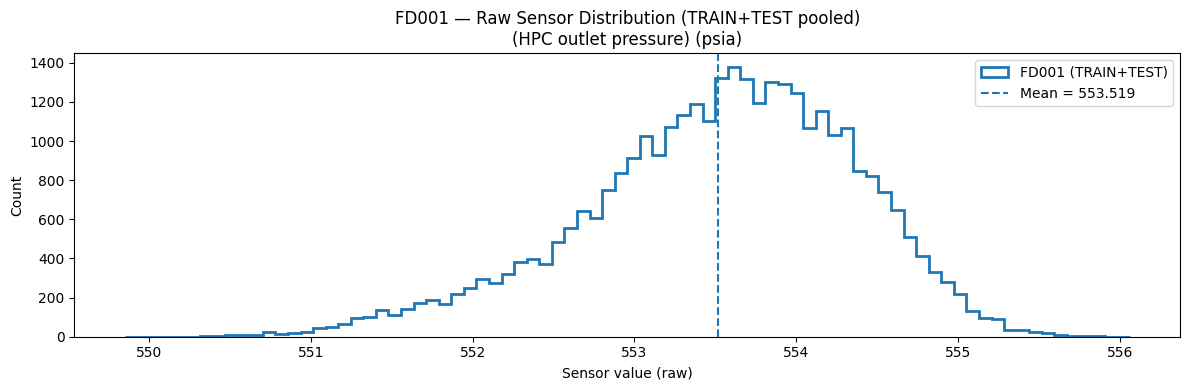

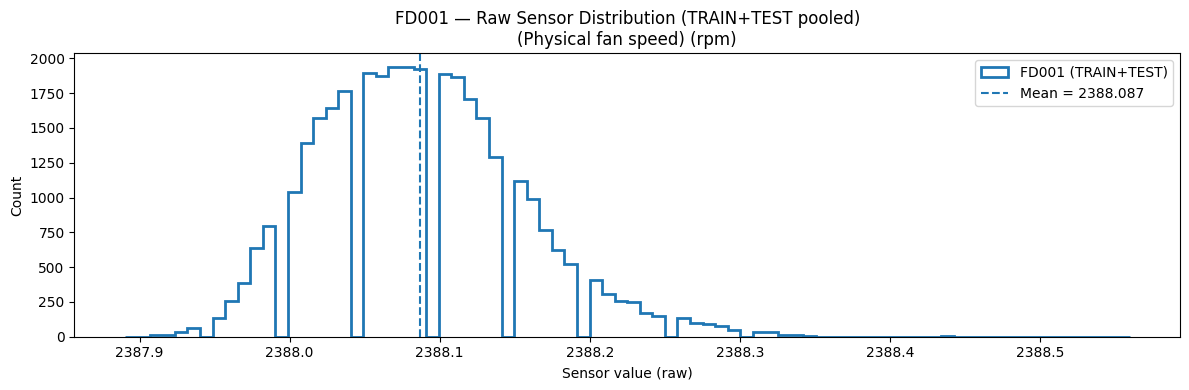

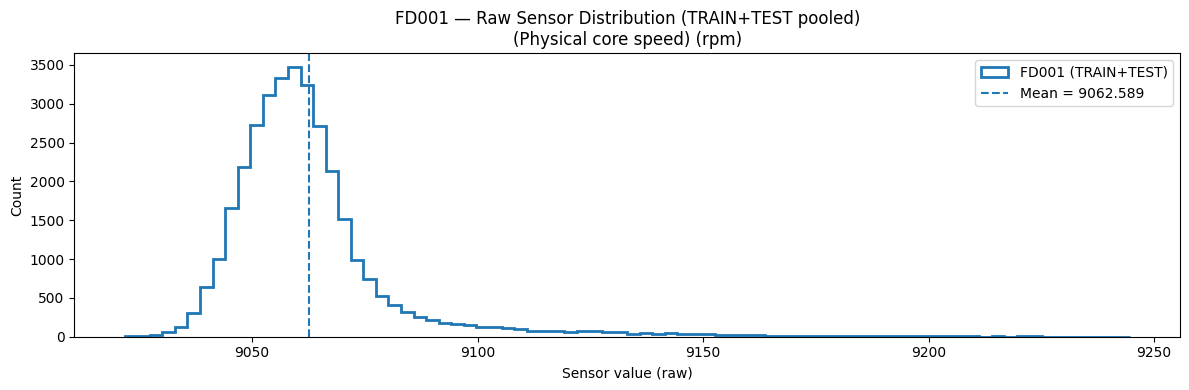

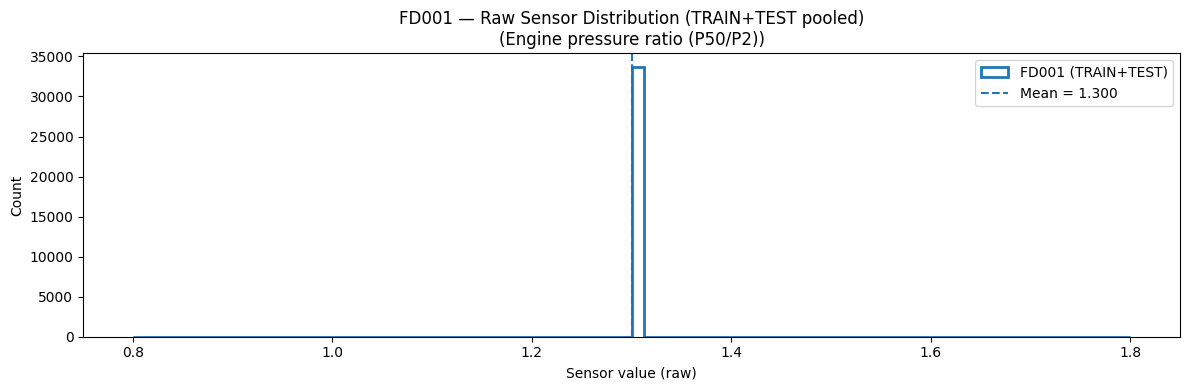

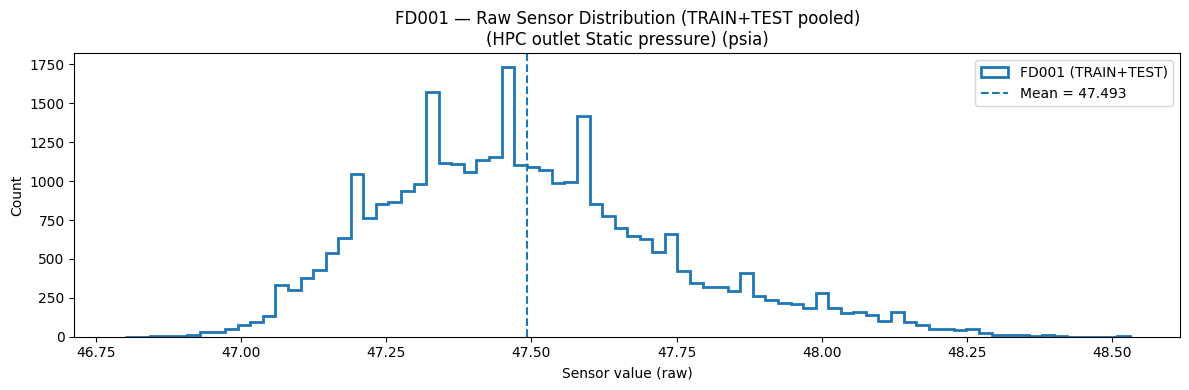

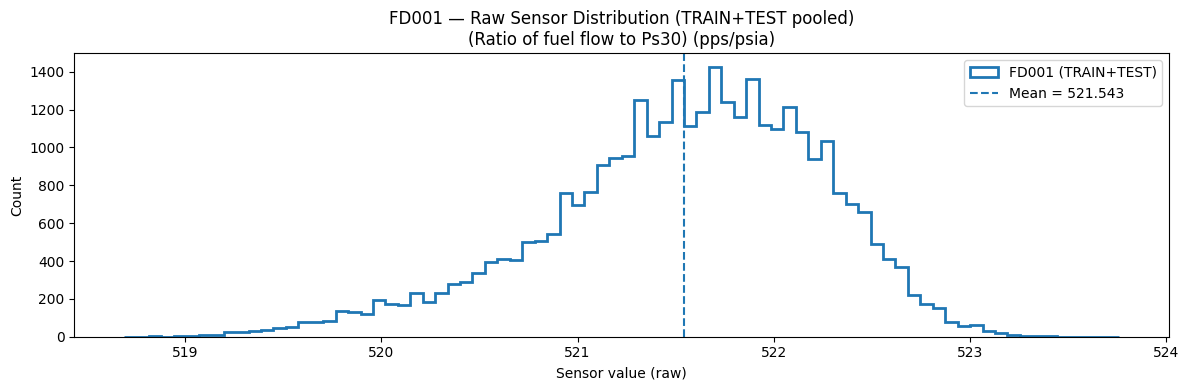

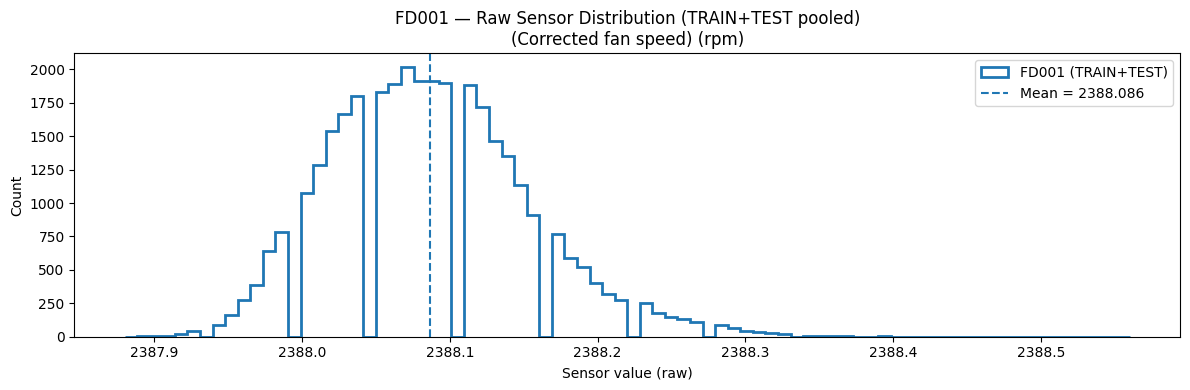

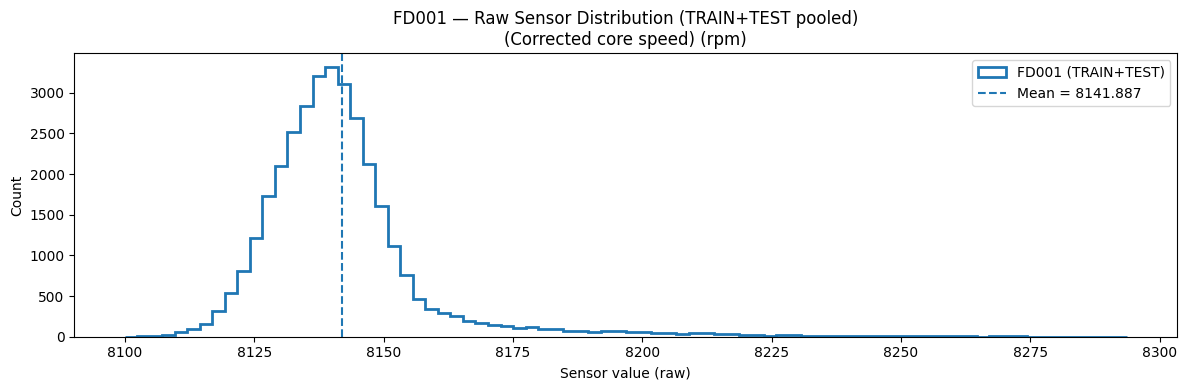

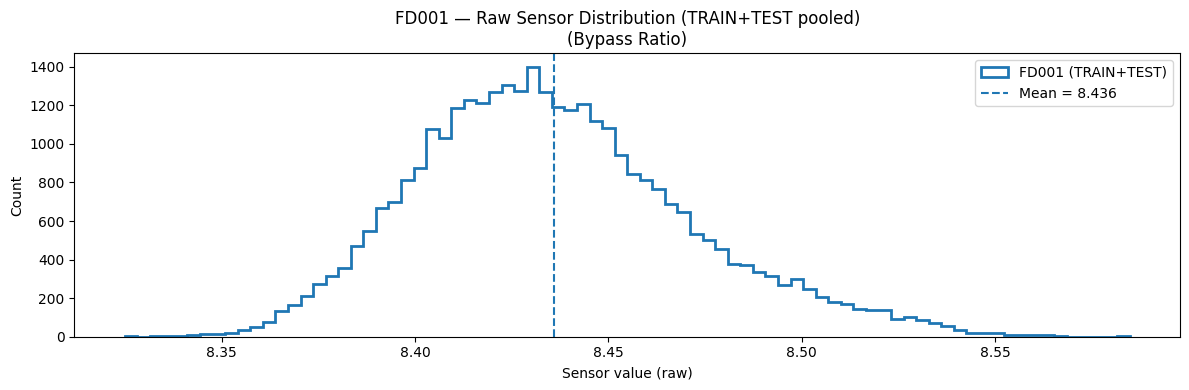

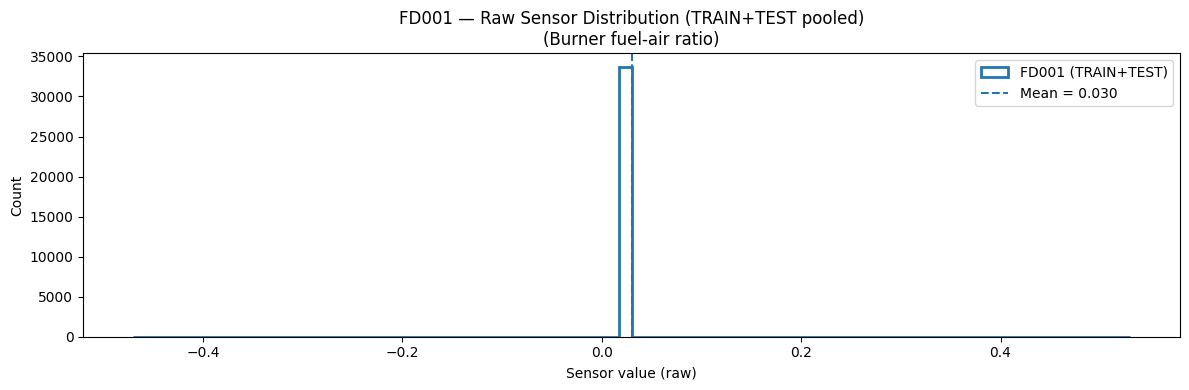

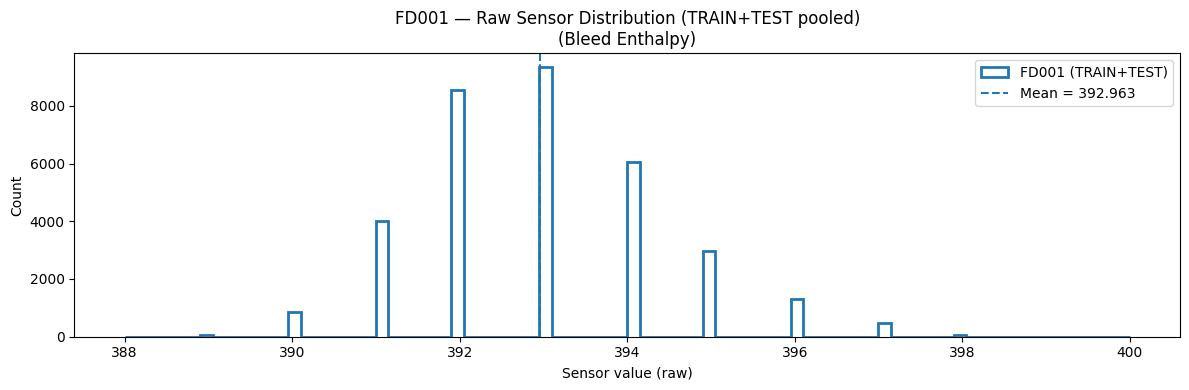

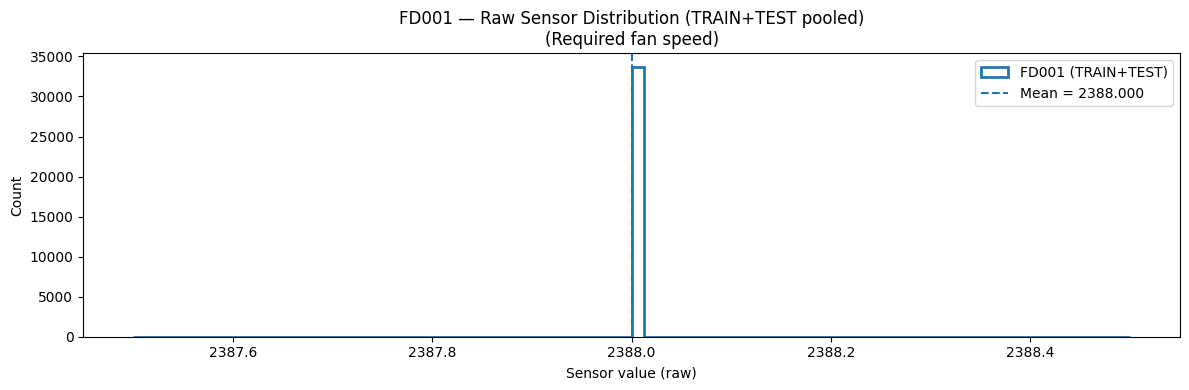

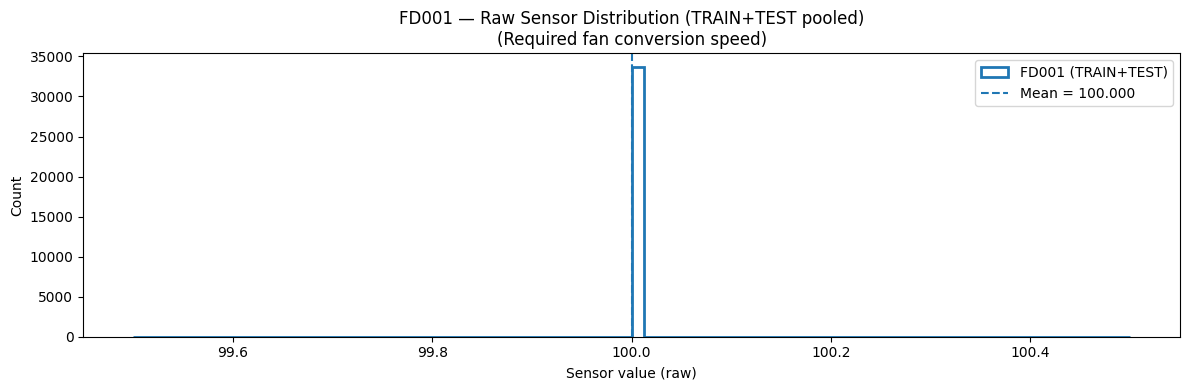

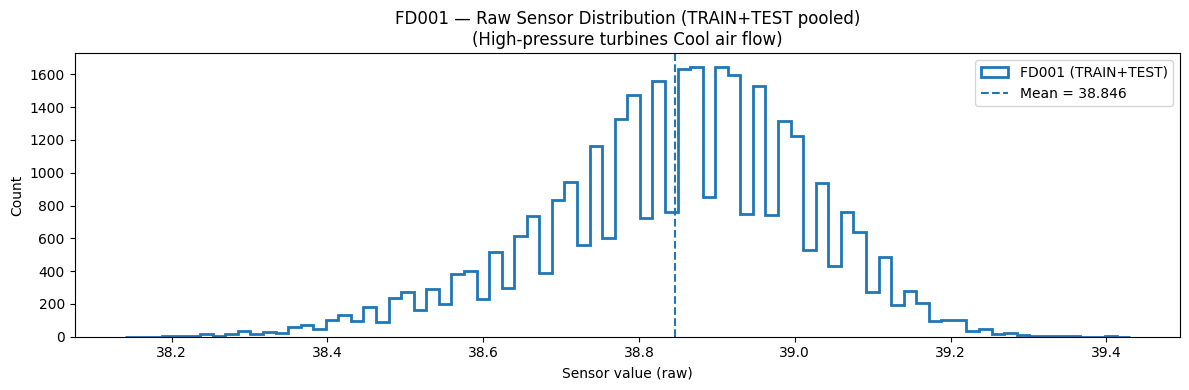

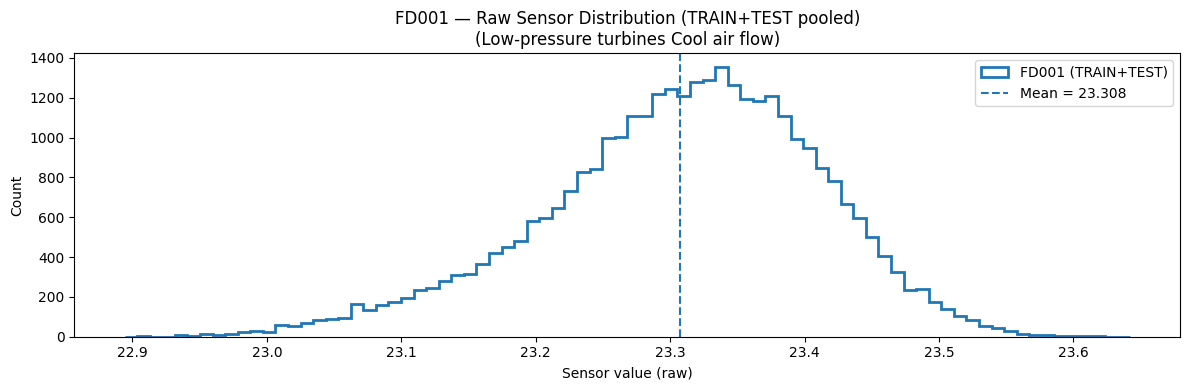

In [15]:
# =========================
# FD001 ONLY — Raw Sensor Distributions (TRAIN + TEST pooled) ✅
# One plot per sensor (≈21 figures)
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure FD001 is loaded
if not all(k in globals() for k in ["train_FD001", "test_FD001"]):
    if "load_cmaps" not in globals():
        raise NameError("FD001 not loaded and load_cmaps() not found. Run the FD001 loader cell first.")
    train_FD001, test_FD001, rul_FD001 = load_cmaps("FD001")
    print("FD001 was not defined -> loaded now using load_cmaps('FD001') ✅")

# Detect sensor columns (your labeled sensors start with "(" )
sensor_cols = [c for c in train_FD001.columns if isinstance(c, str) and c.strip().startswith("(")]
if not sensor_cols:
    raise ValueError("FD001: No sensor columns detected (expected columns starting with '(').")

# Pool raw data (TRAIN + TEST) for FD001
pooled = pd.concat([train_FD001[sensor_cols], test_FD001[sensor_cols]], ignore_index=True)

BINS = 80  # adjust if you want smoother/rougher histograms

# One plot per sensor
for s in sensor_cols:
    vals = pooled[s].dropna().to_numpy()
    if vals.size == 0:
        continue

    mu = float(np.mean(vals))
    bin_edges = np.histogram_bin_edges(vals, bins=BINS)

    plt.figure(figsize=(12, 4))

    # Histogram outline (step) + mean line
    n, bins, patches = plt.hist(vals, bins=bin_edges, histtype="step", linewidth=2, label="FD001 (TRAIN+TEST)")
    try:
        c = patches[0].get_edgecolor()
    except Exception:
        c = None
    plt.axvline(mu, linestyle="--", linewidth=1.5, color=c, label=f"Mean = {mu:.3f}")

    plt.title(f"FD001 — Raw Sensor Distribution (TRAIN+TEST pooled)\n{s}")
    plt.xlabel("Sensor value (raw)")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()



Axis label map (Sxx -> sensor name):
S01: (Fan inlet temperature) (◦R)
S02: (LPC outlet temperature) (◦R)
S03: (HPC outlet temperature) (◦R)
S04: (LPT outlet temperature) (◦R)
S05: (Fan inlet Pressure) (psia)
S06: (bypass-duct pressure) (psia)
S07: (HPC outlet pressure) (psia)
S08: (Physical fan speed) (rpm)
S09: (Physical core speed) (rpm)
S10: (Engine pressure ratio (P50/P2))
S11: (HPC outlet Static pressure) (psia)
S12: (Ratio of fuel flow to Ps30) (pps/psia)
S13: (Corrected fan speed) (rpm)
S14: (Corrected core speed) (rpm)
S15: (Bypass Ratio)
S16: (Burner fuel-air ratio)
S17: (Bleed Enthalpy)
S18: (Required fan speed)
S19: (Required fan conversion speed)
S20: (High-pressure turbines Cool air flow)
S21: (Low-pressure turbines Cool air flow)
RUL: Remaining Useful Life (cycles) computed from TRAIN (run-to-failure)


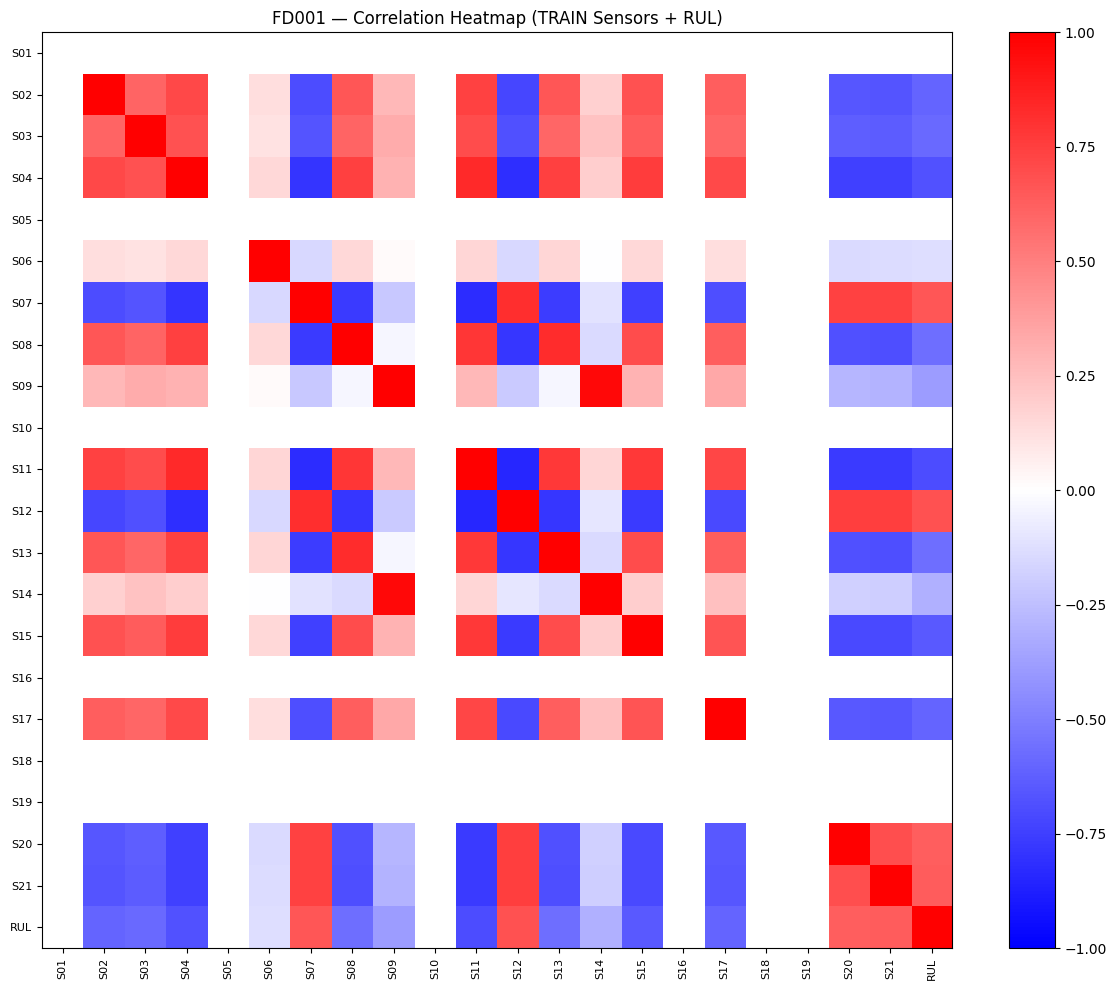


FD001 — Top 10 sensors by |corr with RUL|:


,corr_with_RUL
(HPC outlet Static pressure) (psia),-0.696228
(LPT outlet temperature) (◦R),-0.678948
(Ratio of fuel flow to Ps30) (pps/psia),0.671983
(HPC outlet pressure) (psia),0.657223
(Bypass Ratio),-0.642667
(Low-pressure turbines Cool air flow),0.635662
(High-pressure turbines Cool air flow),0.629428
(LPC outlet temperature) (◦R),-0.606484
(Bleed Enthalpy),-0.606154
(HPC outlet temperature) (◦R),-0.584520


In [16]:
# =========================
# FD001 ONLY — Correlation Heatmap (TRAIN Sensors + RUL) ✅
#   - Uses TRAIN only (run-to-failure) so RUL is consistent per row
#   - Heatmap uses short labels S01..S21 + RUL for readability
# =========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Ensure FD001 is loaded
if not all(k in globals() for k in ["train_FD001"]):
    if "load_cmaps" not in globals():
        raise NameError("FD001 not loaded and load_cmaps() not found. Run the FD001 loader cell first.")
    train_FD001, test_FD001, rul_FD001 = load_cmaps("FD001")
    print("FD001 was not defined -> loaded now using load_cmaps('FD001') ✅")

# Detect sensor columns (your labeled sensors start with "(" )
sensor_cols = [c for c in train_FD001.columns if isinstance(c, str) and c.strip().startswith("(")]
if not sensor_cols:
    raise ValueError("FD001: No sensor columns detected (expected columns starting with '(').")

# Short labels for readability (S01..S21 + RUL)
short_sensors = [f"S{i:02d}" for i in range(1, len(sensor_cols) + 1)]
short_labels = short_sensors + ["RUL"]

print("\nAxis label map (Sxx -> sensor name):")
for k, name in zip(short_sensors, sensor_cols):
    print(f"{k}: {name}")
print("RUL: Remaining Useful Life (cycles) computed from TRAIN (run-to-failure)")

# Use TRAIN only (already has RUL in your loader, but we compute defensively if missing)
train_df = train_FD001.copy()

if "RUL" not in train_df.columns:
    if "engine_id" not in train_df.columns or "cycle" not in train_df.columns:
        raise ValueError("FD001: 'engine_id' and 'cycle' columns are required to compute RUL.")
    max_cycle = train_df.groupby("engine_id")["cycle"].max()
    train_df["RUL"] = train_df["engine_id"].map(max_cycle) - train_df["cycle"]

# Correlation among sensors + RUL
corr_df = train_df[sensor_cols + ["RUL"]]
corr = corr_df.corr(numeric_only=True)

plt.figure(figsize=(12, 10))
im = plt.imshow(corr.values, aspect="auto", vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
plt.xticks(range(len(short_labels)), short_labels, rotation=90, fontsize=8)
plt.yticks(range(len(short_labels)), short_labels, fontsize=8)
plt.title("FD001 — Correlation Heatmap (TRAIN Sensors + RUL)")
plt.tight_layout()
plt.show()

# Top correlations with RUL
rul_corr = corr["RUL"].drop("RUL").sort_values(key=lambda s: s.abs(), ascending=False)
print("\nFD001 — Top 10 sensors by |corr with RUL|:")
display(rul_corr.head(10).to_frame(name="corr_with_RUL"))


## 🔎 FD001 Preview — Single Engine Trajectory (Engine #1)

This cell performs a quick sanity check by isolating **one engine** from the FD001 training fleet.

**What this cell shows**
- Filters the training dataset to **Engine #1**
- Sorts the data by **cycle** to preserve the time sequence ⏳
- Displays:
  - the **first `n` rows (head)** to confirm initial conditions
  - the **last `n` rows (tail)** to confirm the end-of-life region

✅ This helps verify that the dataset is correctly loaded and structured before moving into reliability modeling and APM/CBM analysis.


In [17]:
# =========================
# FD001 — Engine #1 only (head + tail)
# =========================

engine_id = 1
n = 5  # number of rows for head/tail

d = train_FD001[train_FD001["engine_id"] == engine_id].sort_values("cycle")

display(HTML(
    f"<h2 style='text-align:center; margin-top:18px;'>"
    f"FD001 — Engine {engine_id} (total rows={len(d)})"
    f"</h2>"
))

display(d.head(n))
display(d.tail(n))

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),FD,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,FD001,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,FD001,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,FD001,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,FD001,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,FD001,187


,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,(Fan inlet temperature) (◦R),(LPC outlet temperature) (◦R),(HPC outlet temperature) (◦R),(LPT outlet temperature) (◦R),(Fan inlet Pressure) (psia),...,(Corrected core speed) (rpm),(Bypass Ratio),(Burner fuel-air ratio),(Bleed Enthalpy),(Required fan speed),(Required fan conversion speed),(High-pressure turbines Cool air flow),(Low-pressure turbines Cool air flow),FD,RUL
187,1,188,-0.0067,0.0003,100.0,518.67,643.75,1602.38,1422.78,14.62,...,8117.69,8.5207,0.03,396,2388,100.0,38.51,22.9588,FD001,4
188,1,189,-0.0006,0.0002,100.0,518.67,644.18,1596.17,1428.01,14.62,...,8117.51,8.5183,0.03,395,2388,100.0,38.48,23.1127,FD001,3
189,1,190,-0.0027,0.0001,100.0,518.67,643.64,1599.22,1425.95,14.62,...,8112.58,8.5223,0.03,398,2388,100.0,38.49,23.0675,FD001,2
190,1,191,-0.0000,-0.0004,100.0,518.67,643.34,1602.36,1425.77,14.62,...,8114.61,8.5174,0.03,394,2388,100.0,38.45,23.1295,FD001,1
191,1,192,0.0009,-0.0000,100.0,518.67,643.54,1601.41,1427.20,14.62,...,8110.93,8.5113,0.03,396,2388,100.0,38.48,22.9649,FD001,0


# 🚀 ISE-506 (Advanced Reliability Engineering)

## 🧩 ISE-506 (Advanced Reliability Engineering) — Reliability Analysis ⚙️📉

In this section, we focus on **quantitative reliability analysis** for turbofan engines using the NASA C-MAPSS FD001 dataset.

**Main idea:** treat each engine in the TRAIN set as a **run-to-failure experiment** ✅  
This allows us to extract a **lifetime (cycles-to-failure)** for every engine and build a fleet-level reliability model.

What we will do in ISE-506:
- 📌 Extract **engine lifetimes** from FD001 TRAIN (cycles-to-failure)
- 📈 Fit a **Weibull reliability model** to represent fleet survival behavior
- 🧾 Use **Kaplan–Meier (KM)** as a data-driven reference for validation
- 🔮 Apply the fitted model to FD001 TEST by using each engine’s **current age** (t_current) to estimate:
  - current reliability (how “safe” the engine is now)
  - near-future survival probability over a chosen horizon (tau)

**Outcome:** a clear, defendable reliability model that quantifies how failure risk changes with operating cycles and provides the reliability foundation needed for maintenance decision-making in the next section (ISE-510) 🛠️.


# 1️⃣ ISE-506 — Reliability Modeling (FD001) ⚙️📉

FD001 TRAIN is **run-to-failure** ✅, meaning each engine is observed until it fails.  
So, the lifetime of each engine is defined as:

- **Lifetime (cycles-to-failure)** for engine *i* = the **last recorded cycle** in TRAIN (max(cycle)).

Using all engine lifetimes, we fit a **2-parameter Weibull model** (location fixed to 0).  
Key Weibull parameters:
- **beta (shape)** 🧩: describes how failure risk changes with age  
  - beta > 1 → **wear-out behavior** (risk increases with age) 📈
- **eta (scale)** 🎯: the life scale that controls how fast reliability decays

We also compute the **Kaplan–Meier (KM)** empirical survival curve 🧾.  
KM is a **data-driven reliability curve** (non-parametric) and does not assume any distribution.



In [18]:
# =========================
# ISE-506: Fleet Reliability Modeling (FD001)
# Train data is run-to-failure => lifetimes available
# =========================

# 1) Lifetimes from TRAIN (cycles-to-failure)
life = (
    train_FD001.groupby("engine_id")["cycle"]
    .max()
    .to_numpy(dtype=float)
)
n = len(life)

print(f"FD001 TRAIN engines = {n}")
print(f"Life cycles [min, max] = [{int(life.min())}, {int(life.max())}]")

# 2) Weibull fit (2-parameter; loc fixed to 0)
beta, loc, eta = weibull_min.fit(life, floc=0)

# Weibull reliability and conditional reliability
def R_weibull(t: float) -> float:
    t = max(float(t), 0.0)
    return float(np.exp(- (t / eta) ** beta))

def R_cond_weibull(t: float, tau: float) -> float:
    t = max(float(t), 0.0)
    tau = max(float(tau), 0.0)
    Rt = R_weibull(t)
    return 0.0 if Rt <= 0 else float(R_weibull(t + tau) / Rt)

# MTTF for Weibull
MTTF = float(eta * gamma(1.0 + 1.0 / beta))

print(f"Weibull fit (floc=0): beta={beta:.4f}, eta={eta:.4f}")
print(f"MTTF (Weibull) ≈ {MTTF:.2f} cycles")

# 3) Kaplan–Meier (empirical survival) from TRAIN (no censoring)
fail_counts = pd.Series(life).value_counts().sort_index()
times_km = fail_counts.index.to_numpy(dtype=float)
cum_fail = fail_counts.cumsum().to_numpy(dtype=float)
R_km = 1.0 - (cum_fail / n)   # stepwise survival

def R_km_at(t: float) -> float:
    t = float(t)
    if t < times_km[0]:
        return 1.0
    if t >= times_km[-1]:
        return float(R_km[-1])
    idx = np.searchsorted(times_km, t, side="right") - 1
    return float(R_km[idx])


FD001 TRAIN engines = 100
Life cycles [min, max] = [128, 362]
Weibull fit (floc=0): beta=4.4087, eta=225.0259
MTTF (Weibull) ≈ 205.11 cycles


# 2️⃣ Model Validation: KM vs Weibull 🔍✅

This plot compares:
- **KM (empirical survival)** 🧾: stepwise reliability curve built directly from observed lifetimes, and
- **Weibull fit** 📈: smooth parametric reliability curve.

If the Weibull curve follows the KM trend closely, it is a **reasonable fleet-level reliability model** ✅.  
This matters because Weibull provides a smooth function that is useful for **planning, forecasting, and optimization** in maintenance decisions 🛠️.



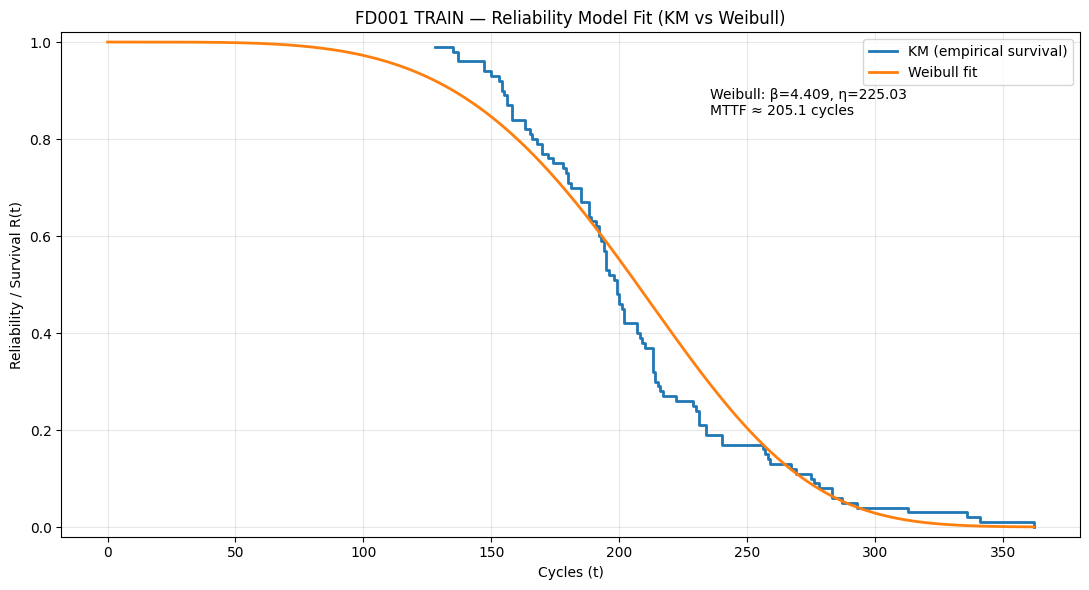

In [19]:
# =========================
# Plot: KM vs Weibull (model fit check)
# =========================
t_grid = np.linspace(0, life.max(), 400)

plt.figure(figsize=(11, 6))
plt.step(times_km, R_km, where="post", linewidth=2.0, label="KM (empirical survival)")
plt.plot(t_grid, np.exp(- (t_grid / eta) ** beta), linewidth=2.0, label="Weibull fit")

plt.title("FD001 TRAIN — Reliability Model Fit (KM vs Weibull)")
plt.xlabel("Cycles (t)")
plt.ylabel("Reliability / Survival R(t)")
plt.ylim(-0.02, 1.02)
plt.grid(True, alpha=0.3)
plt.legend()

plt.annotate(
    f"Weibull: β={beta:.3f}, η={eta:.2f}\nMTTF ≈ {MTTF:.1f} cycles",
    xy=(0.65 * float(life.max()), 0.85),
    xycoords="data"
)

plt.tight_layout()
plt.show()


# 3️⃣ Goodness-of-Fit Summary 🧪📌

To summarize the Weibull fit quality with simple numbers:

- **KS D (Kolmogorov–Smirnov distance)** 📏  
  Maximum difference between the empirical CDF and Weibull CDF.  
  Interpretation: **worst-case mismatch** between data and fitted model.

- **RMSE on reliability** 🎯  
  Average mismatch between empirical survival values and Weibull survival values
  evaluated at the observed failure times.

These metrics are included only as compact support 🧾; the primary validation remains the **KM vs Weibull plot** ✅.

In [20]:
# =========================
# GOF: KS D and RMSE (no p-value)
# =========================
t_sorted = np.sort(life)
F_emp = np.arange(1, n + 1) / n
F_wbl = weibull_min.cdf(t_sorted, c=beta, loc=0, scale=eta)

KS_D = float(np.max(np.abs(F_emp - F_wbl)))

R_emp = 1.0 - F_emp
R_wbl = 1.0 - F_wbl
RMSE_R = float(np.sqrt(np.mean((R_emp - R_wbl) ** 2)))

print(f"GOF (KS D)  = {KS_D:.4f}   (max |F_emp - F_weibull|)")
print(f"GOF (RMSE R)= {RMSE_R:.4f}  (average mismatch in reliability)")


GOF (KS D)  = 0.1565   (max |F_emp - F_weibull|)
GOF (RMSE R)= 0.0725  (average mismatch in reliability)


# 4️⃣ Applying the Weibull Model to TEST Engines (Censored Data) 🛰️🧠

FD001 TEST data is **censored** ⛔ (engines do not reach failure in the test file).  
For each test engine, we define its current age as:

- **t_current** = the **last recorded cycle** in TEST for that engine.

Using the fitted Weibull model, we compute per-engine risk metrics 🧾:

- **R(t_current)** ✅: probability an engine survives beyond its current age (age-based reliability)
- **R(tau | t_current)** 🔮: probability the engine survives the next **tau** cycles given it is alive now
- **P(fail in next tau)** ⚠️: equals 1 − R(tau | t_current)

In this notebook, reliability and failure probabilities are reported in **percent (%)** for readability 📊.

In [21]:
# =========================
# Apply model to TEST: engine-specific age-based reliability at t_current
# =========================
current_age = (
    test_FD001.groupby("engine_id")["cycle"]
    .max()
    .reset_index(name="t_current")
    .sort_values("engine_id")
    .reset_index(drop=True)
)

tau = 50  # horizon (next 50 cycles)

current_age["R(t_current) [%]"] = current_age["t_current"].apply(lambda t: 100.0 * R_weibull(t))
current_age["R(tau|t_current) [%]"] = current_age["t_current"].apply(lambda t: 100.0 * R_cond_weibull(t, tau))
current_age["P_fail_next_tau [%]"] = 100.0 - current_age["R(tau|t_current) [%]"]

cols_pct = ["R(t_current) [%]", "R(tau|t_current) [%]", "P_fail_next_tau [%]"]
current_age[cols_pct] = current_age[cols_pct].round(2)

print(f"Computed per-engine reliability for {len(current_age)} TEST engines (tau={tau}).")

with pd.option_context(
    "display.max_rows", None,
    "display.width", 160,
    "display.float_format", "{:.2f}".format
):
    display(current_age)


Computed per-engine reliability for 100 TEST engines (tau=50).


,engine_id,t_current,R(t_current) [%],R(tau|t_current) [%],P_fail_next_tau [%]
0,1,31,99.98,98.92,1.08
1,2,49,99.88,97.47,2.53
2,3,126,92.54,77.04,22.96
3,4,106,96.45,84.99,15.01
4,5,98,97.47,87.63,12.37
5,6,105,96.59,85.34,14.66
6,7,160,80.06,59.75,40.25
7,8,166,76.99,56.36,43.64
8,9,55,99.80,96.78,3.22
9,10,192,60.85,41.43,58.57


# 5️⃣ Visualization: Conditional Reliability Curves for All TEST Engines 📈

This figure shows conditional reliability curves for all engines in FD001 TEST:

- Each curve starts at **1.0 at tau = 0** ✅ because the engine is currently operating.
- The curve decreases as **tau increases** (further into the future) ⏳.
- Engines with larger **t_current** (older engines) generally drop faster ⚠️ because they are closer to wear-out.

This provides an intuitive fleet monitoring view of near-future survival probability for each engine 🛠️📉.

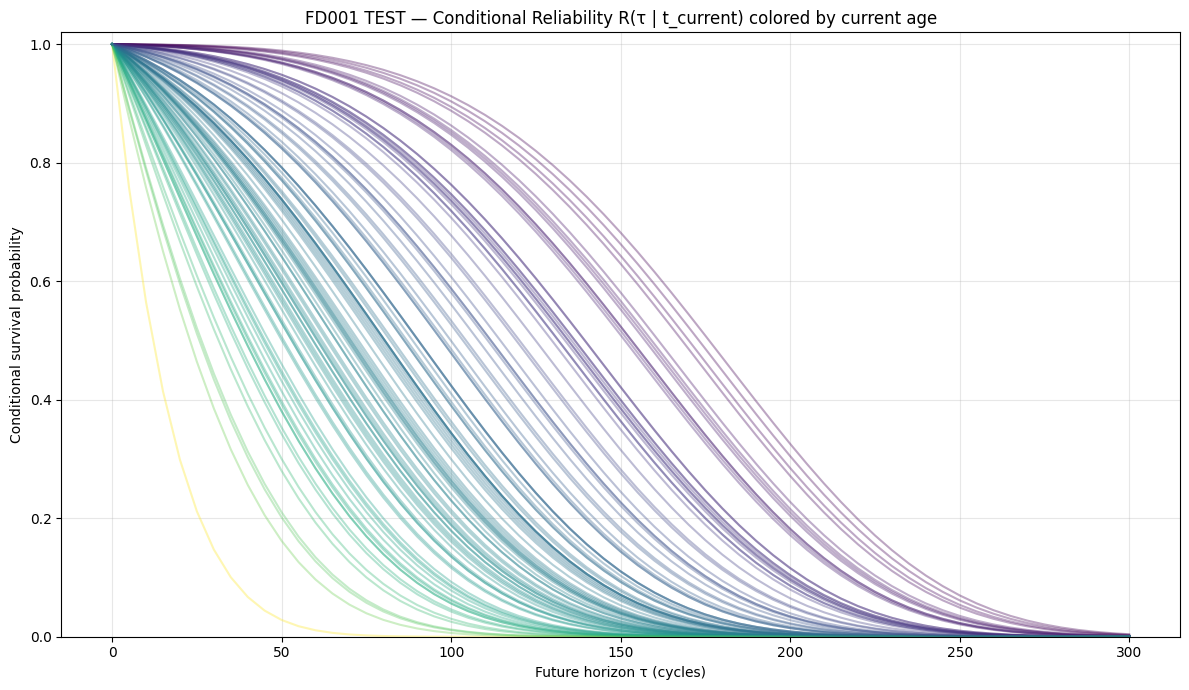

In [22]:
# =========================
# Plot: Conditional reliability curves R(τ | t_current) for all TEST engines
# =========================
horizon = 300
step = 5
taus = np.arange(0, horizon + 1, step)

plt.figure(figsize=(12, 7))

tmin, tmax = float(current_age["t_current"].min()), float(current_age["t_current"].max())

for _, r in current_age.iterrows():
    t0 = float(r["t_current"])
    y = [R_cond_weibull(t0, tau_) for tau_ in taus]

    # color by age (older engines darker)
    c = (t0 - tmin) / (tmax - tmin + 1e-12)
    plt.plot(taus, y, alpha=0.35, color=plt.cm.viridis(c))

plt.title("FD001 TEST — Conditional Reliability R(τ | t_current) colored by current age")
plt.xlabel("Future horizon τ (cycles)")
plt.ylabel("Conditional survival probability")
plt.ylim(0, 1.02)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


# 🚀 ISE 510 (Maintenanc Systems Management):

## 🧭 Transition: From Reliability (ISE-506) ➜ Maintenance Strategy (ISE-510) 🛠️📈

In the ISE-506 section, we built a **fleet reliability model** (Weibull) using FD001 TRAIN lifetimes ⚙️📉.  
We then used it to estimate:
- ✅ **current age-based reliability** for each TEST engine (based on its t_current), and
- 🔮 **near-future survival probability** over a planning horizon (tau).

These results provide an **age-based** risk view — very useful for fleet-level reliability and planning 📊.

However, real maintenance programs often perform better when decisions are driven by **condition**, not age alone 🧠.  
Two engines may have the same operating age, yet degrade differently due to operating conditions and internal health state.

### What changes in ISE-510? 🚀
In the ISE-510 section, we shift to an **Asset Performance Management (APM)** mindset 🛰️:
- 📡 continuous monitoring of sensor data,
- 🧩 combining multiple sensor signals into an **Engine Health Index (HI)**,
- 🤖 using **machine learning** to support **Condition-Based Maintenance (CBM)** and optimize decision-making.

🎯 **Goal:** build a practical monitoring and decision framework where inspections/maintenance actions are triggered by **engine condition** (HI and/or predicted RUL), while still being consistent with the reliability foundation established in ISE-506 ✅.


## 0️⃣ ISE-510 Setup (Costs, Downtime, Safety Rules, Feature Set) 🧰💰🛡️

**What this cell does**
- Defines the **economic model** for maintenance decisions: inspection cost, planned maintenance (PM) cost, and failure cost 💵
- Adds **downtime penalties** (hours × $/hr) for inspections, PM, and failures ⏱️💸
- Sets a **safety constraint** by limiting the allowable unplanned failure rate 🛡️
- Defines a **“late PM” rule** using a minimum buffer on true RUL at the trigger ⚠️
- Verifies FD001 data includes all required columns/features ✅

**Key parameters**
- Costs: `C_INSPECT`, `C_PM`, `C_FAIL` 💰  
- Downtime: `D_INSPECT_HR`, `D_PM_HR`, `D_FAIL_HR`, `C_DOWNTIME_HR` ⏱️  
- Safety: `MAX_UNPLANNED_FAIL_RATE` 🛡️  
- Late-PM rule: `MIN_TRUE_RUL_AT_PM` 🚨  

**Why it matters**
This sets the **cost–risk trade-off**: avoid early expensive PM, but also avoid unplanned failures (highest cost + downtime) 🎯


In [23]:
# =========================
# ISE-510 (FD001) — APM + CBM (HI from original data + Deep RUL + Cost Optimization)
# =========================

import numpy as np
import pandas as pd

# ---- Costs (ASSUMED) ----
# Currency: USD $
C_INSPECT = 10_000
C_PM      = 1_500_000
C_FAIL    = 5_000_000

# Downtime costs (set to 0 if you want to ignore downtime)
D_INSPECT_HR   = 4
D_PM_HR        = 72
D_FAIL_HR      = 168
C_DOWNTIME_HR  = 5_000  # $/hr

# Safety constraint
MAX_UNPLANNED_FAIL_RATE = 0.10  # 10%

# Rule: PM is "late" if true RUL at trigger is <= this threshold
MIN_TRUE_RUL_AT_PM = 20  # cycles

# Feature columns (must exist from earlier cells)
feature_cols = ["op_setting_1", "op_setting_2", "op_setting_3"] + SENSOR_NAMES

# Sanity checks
need_train = set(["engine_id", "cycle", "RUL"]) | set(feature_cols)
need_test  = set(["engine_id", "cycle"])       | set(feature_cols)

missing_train = need_train - set(train_FD001.columns)
missing_test  = need_test  - set(test_FD001.columns)

if missing_train:
    raise ValueError(f"Missing columns in train_FD001: {missing_train}")
if missing_test:
    raise ValueError(f"Missing columns in test_FD001: {missing_test}")

print("ISE-510 setup OK ✅")


ISE-510 setup OK ✅


## 1️⃣ Health Index (HI) from Original Sensor Features (Explainable) 📈🧠🔍

**What this cell does**
- Builds an **explainable Health Index (HI)** directly from original operating settings + sensors (no PCA) 🧩
- Trains **Ridge regression** to map standardized features → capped RUL 🧠
- Uses **GroupKFold by engine_id** to prevent leakage (engines stay separated) 🚫🔄
- Converts predicted capped-RUL to a **0–1 HI scale** using MinMax:
  - **HI ≈ 1** → healthy ✅  
  - **HI ≈ 0** → degraded ⚠️
- Prints **HI–RUL correlation** + shows top features by importance 🏅

**Key takeaway**
This HI is **stable + interpretable**, which is great for industrial CBM dashboards 👷‍♂️📊


In [24]:
# =========================
# 1) Health Index (HI) from ORIGINAL features (no PCA) ✅
#    - Ridge regression on capped RUL
#    - GroupKFold(engine-wise) to select alpha (no leakage)
#    - HI = MinMax(normalized predicted capped-RUL) => higher HI = healthier
# =========================

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error

train_FD001 = train_FD001.copy()
test_FD001  = test_FD001.copy()

# Remove old columns (avoid collisions)
for c in ["HI", "HI_pred", "RUL_pred_DL", "HI_decision"]:
    train_FD001.drop(columns=[c], errors="ignore", inplace=True)
    test_FD001.drop(columns=[c], errors="ignore", inplace=True)

# 1) Standardize original features (fit on TRAIN only)
scaler_feat = StandardScaler()
Xtr = scaler_feat.fit_transform(train_FD001[feature_cols])
Xte = scaler_feat.transform(test_FD001[feature_cols])

ytr = train_FD001["RUL"].to_numpy(dtype=float)
groups = train_FD001["engine_id"].to_numpy(dtype=int)

# Optional: cap RUL to reduce early-life noise
RUL_CAP_HI = 125
ytr_cap = np.minimum(ytr, RUL_CAP_HI)

# 2) Select alpha via GroupKFold
alphas = np.logspace(-3, 4, 20)
gkf = GroupKFold(n_splits=5)

best_alpha = None
best_rmse = np.inf

for a in alphas:
    oof = np.zeros_like(ytr_cap, dtype=float)

    for tr_idx, va_idx in gkf.split(Xtr, ytr_cap, groups=groups):
        m = Ridge(alpha=float(a))
        m.fit(Xtr[tr_idx], ytr_cap[tr_idx])
        oof[va_idx] = m.predict(Xtr[va_idx])

    rmse = float(np.sqrt(mean_squared_error(ytr_cap, oof)))
    if rmse < best_rmse:
        best_rmse = rmse
        best_alpha = float(a)

print(f"HI model: best alpha = {best_alpha:.4g} | GroupKFold RMSE (capped RUL) = {best_rmse:.2f} cycles")

# 3) Fit final model and compute HI
hi_model = Ridge(alpha=best_alpha)
hi_model.fit(Xtr, ytr_cap)

hi_raw_tr = hi_model.predict(Xtr)
hi_raw_te = hi_model.predict(Xte)

hi_scaler = MinMaxScaler((0, 1))
train_FD001["HI"] = hi_scaler.fit_transform(hi_raw_tr.reshape(-1, 1)).ravel()
test_FD001["HI"]  = hi_scaler.transform(hi_raw_te.reshape(-1, 1)).ravel()

corr_hi = float(np.corrcoef(train_FD001["HI"].to_numpy(), ytr)[0, 1])
print(f"HI vs true RUL correlation (TRAIN) = {corr_hi:.3f} ✅")

# Show most influential features
w = hi_model.coef_.astype(float)
top_idx = np.argsort(-np.abs(w))[:10]
print("Top 10 ORIGINAL features by |weight|:")
for idx in top_idx:
    print(f"  {feature_cols[idx]}  w={w[idx]:+.4f}")

display(train_FD001[["engine_id","cycle","RUL","HI"]].head(10))


HI model: best alpha = 336 | GroupKFold RMSE (capped RUL) = 21.57 cycles
HI vs true RUL correlation (TRAIN) = 0.760 ✅
Top 10 ORIGINAL features by |weight|:
  (HPC outlet Static pressure) (psia)  w=-5.7984
  (Physical core speed) (rpm)  w=-5.7895
  (Ratio of fuel flow to Ps30) (pps/psia)  w=+5.1596
  (Corrected core speed) (rpm)  w=-4.4919
  (LPT outlet temperature) (◦R)  w=-4.1474
  (HPC outlet pressure) (psia)  w=+4.1086
  (Bypass Ratio)  w=-3.3177
  (High-pressure turbines Cool air flow)  w=+2.5551
  (Low-pressure turbines Cool air flow)  w=+2.4986
  (LPC outlet temperature) (◦R)  w=-2.3348


,engine_id,cycle,RUL,HI
0,1,1,191,0.839985
1,1,2,190,0.829469
2,1,3,189,0.857856
3,1,4,188,0.899964
4,1,5,187,0.826004
5,1,6,186,0.883273
6,1,7,185,0.859240
7,1,8,184,0.879558
8,1,9,183,0.877347
9,1,10,182,0.859752


## 2️⃣ Deep RUL Prediction Model (LSTM → GRU, Windowed, Engine-wise CV) 🤖🧬🛰️

**What this cell does**
- Trains a sequence model (**LSTM→GRU**) to predict RUL from **time-series windows** 🧠⏳
- Builds many samples via sliding windows (`WINDOW`, `STRIDE`) 🪟
- Uses **GroupKFold(engine_id)** so validation engines are unseen (no leakage) 🚫🧪
- Applies early stopping and reports OOF errors:
  - **all windows** 📉
  - **last window per engine** (closest to real deployment) 🎯
- Outputs an ensemble list: `final_models` ✅

**Key takeaway**
The deep model learns **temporal degradation patterns**, beyond linear HI 🔥


In [25]:
# =========================
# 2) Deep RUL model (LSTM->GRU) with GroupKFold + Multi-seed ✅
#    Output: final_models (ensemble) + windowed training meta
# =========================

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import GroupKFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

# DL hyperparameters
WINDOW = 30
STRIDE = 1
RUL_CAP_DL = 125

K_FOLDS = 5
SEEDS = [0, 1, 2]

EPOCHS = 35
PATIENCE = 6
BATCH = 256
LR = 1e-3
HIDDEN = 64
DROPOUT = 0.2
WEIGHT_DECAY = 1e-5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

def set_seed(seed: int):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def cap_rul(y, cap):
    return np.minimum(y, cap) if cap is not None else y

def make_windows_train(df, X_scaled, window=30, stride=1, rul_cap=125):
    X_list, y_list, e_list, end_list = [], [], [], []
    df = df.reset_index(drop=True)

    for eid, idxs in df.groupby("engine_id").indices.items():
        idxs = np.array(sorted(idxs))
        d = df.loc[idxs].sort_values("cycle")
        idxs_sorted = d.index.to_numpy()

        Xe = X_scaled[idxs_sorted]
        ye = d["RUL"].to_numpy(dtype=np.float32)
        ye = cap_rul(ye, rul_cap)

        T = len(d)
        if T < window:
            continue

        cycles = d["cycle"].to_numpy()
        for end in range(window - 1, T, stride):
            start = end - window + 1
            X_list.append(Xe[start:end+1])
            y_list.append(ye[end])
            e_list.append(int(eid))
            end_list.append(int(cycles[end]))

    X = np.stack(X_list).astype(np.float32)
    y = np.asarray(y_list, dtype=np.float32)
    meta = pd.DataFrame({"engine_id": e_list, "end_cycle": end_list})
    return X, y, meta

class SeqDS(Dataset):
    def __init__(self, X, y=None):
        self.X = torch.from_numpy(X)
        self.y = None if y is None else torch.from_numpy(y)
    def __len__(self): return len(self.X)
    def __getitem__(self, i):
        if self.y is None: return self.X[i]
        return self.X[i], self.y[i]

class LSTMGRU(nn.Module):
    def __init__(self, n_features, hidden=64, dropout=0.2):
        super().__init__()
        self.lstm = nn.LSTM(n_features, hidden, batch_first=True)
        self.gru  = nn.GRU(hidden, hidden, batch_first=True)
        self.head = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden//2, 1)
        )
    def forward(self, x):
        out, _ = self.lstm(x)
        out, _ = self.gru(out)
        last = out[:, -1, :]
        return self.head(last).squeeze(-1)

@torch.no_grad()
def predict_model(model, X):
    model.eval()
    loader = DataLoader(SeqDS(X, None), batch_size=BATCH, shuffle=False)
    out = []
    for xb in loader:
        xb = xb.to(DEVICE)
        out.append(model(xb).detach().cpu().numpy())
    return np.concatenate(out)

def train_fold(Xtr, ytr, Xva, yva, seed):
    set_seed(seed)
    model = LSTMGRU(n_features=Xtr.shape[-1], hidden=HIDDEN, dropout=DROPOUT).to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    tr_loader = DataLoader(SeqDS(Xtr, ytr), batch_size=BATCH, shuffle=True)
    va_loader = DataLoader(SeqDS(Xva, yva), batch_size=BATCH, shuffle=False)

    best_rmse = np.inf
    best_state = None
    patience = PATIENCE

    for _ in range(EPOCHS):
        model.train()
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

        # val RMSE
        vp = []
        model.eval()
        with torch.no_grad():
            for xb, _yb in va_loader:
                xb = xb.to(DEVICE)
                vp.append(model(xb).detach().cpu().numpy())
        vp = np.concatenate(vp)
        rmse = float(np.sqrt(np.mean((vp - yva) ** 2)))

        if rmse < best_rmse - 1e-4:
            best_rmse = rmse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            patience = PATIENCE
        else:
            patience -= 1
            if patience <= 0:
                break

    model.load_state_dict(best_state)
    return model, best_rmse

# Build windows on TRAIN (re-using scaler_feat from Cell #1)
Xtr_scaled = scaler_feat.transform(train_FD001[feature_cols]).astype(np.float32)
X_win, y_win, meta_win = make_windows_train(train_FD001, Xtr_scaled, window=WINDOW, stride=STRIDE, rul_cap=RUL_CAP_DL)

groups_win = meta_win["engine_id"].to_numpy(dtype=int)
print("DL windows:", X_win.shape, y_win.shape)

gkf_win = GroupKFold(n_splits=K_FOLDS)

# OOF for reporting
oof_pred = np.zeros_like(y_win, dtype=np.float32)

for seed in SEEDS:
    pred_seed = np.zeros_like(y_win, dtype=np.float32)

    for fold, (tr_idx, va_idx) in enumerate(gkf_win.split(X_win, y_win, groups=groups_win), 1):
        model_f, rmse_f = train_fold(X_win[tr_idx], y_win[tr_idx], X_win[va_idx], y_win[va_idx], seed=seed)
        pred_seed[va_idx] = predict_model(model_f, X_win[va_idx]).astype(np.float32)
        print(f"Seed {seed} | Fold {fold}/{K_FOLDS} | best RMSE={rmse_f:.2f}")

    oof_pred += pred_seed / len(SEEDS)

rmse_oof = float(np.sqrt(mean_squared_error(y_win, oof_pred)))
mae_oof  = float(mean_absolute_error(y_win, oof_pred))
print(f"\nDeep Model OOF (all windows): RMSE={rmse_oof:.2f} | MAE={mae_oof:.2f}")

# LAST window per engine
last_idx = meta_win.groupby("engine_id")["end_cycle"].idxmax().to_numpy()
rmse_last = float(np.sqrt(mean_squared_error(y_win[last_idx], oof_pred[last_idx])))
print(f"Deep Model OOF (LAST window per engine): RMSE={rmse_last:.2f}")

# Train final models on full data (simple early-stop split using one fold)
final_models = []
tr_idx0, va_idx0 = next(iter(gkf_win.split(X_win, y_win, groups=groups_win)))

for seed in SEEDS:
    set_seed(seed)
    m = LSTMGRU(n_features=X_win.shape[-1], hidden=HIDDEN, dropout=DROPOUT).to(DEVICE)
    opt = torch.optim.Adam(m.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    loss_fn = nn.MSELoss()

    tr_loader = DataLoader(SeqDS(X_win[tr_idx0], y_win[tr_idx0]), batch_size=BATCH, shuffle=True)
    va_loader = DataLoader(SeqDS(X_win[va_idx0], y_win[va_idx0]), batch_size=BATCH, shuffle=False)

    best_rmse = np.inf
    best_state = None
    patience = PATIENCE

    for _ in range(EPOCHS):
        m.train()
        for xb, yb in tr_loader:
            xb = xb.to(DEVICE); yb = yb.to(DEVICE)
            opt.zero_grad(set_to_none=True)
            pred = m(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            nn.utils.clip_grad_norm_(m.parameters(), 1.0)
            opt.step()

        vp = []
        m.eval()
        with torch.no_grad():
            for xb, _yb in va_loader:
                xb = xb.to(DEVICE)
                vp.append(m(xb).detach().cpu().numpy())
        vp = np.concatenate(vp)
        rmse = float(np.sqrt(np.mean((vp - y_win[va_idx0]) ** 2)))

        if rmse < best_rmse - 1e-4:
            best_rmse = rmse
            best_state = {k: v.detach().cpu().clone() for k, v in m.state_dict().items()}
            patience = PATIENCE
        else:
            patience -= 1
            if patience <= 0:
                break

    m.load_state_dict(best_state)
    final_models.append(m)
    print(f"Final model trained (seed={seed}) | early-stop RMSE≈{best_rmse:.2f}")

print("Final deep models ready ✅")


DEVICE: cpu
DL windows: (17731, 30, 24) (17731,)


Seed 0 | Fold 1/5 | best RMSE=14.47
Seed 0 | Fold 2/5 | best RMSE=14.61
Seed 0 | Fold 3/5 | best RMSE=12.50
Seed 0 | Fold 4/5 | best RMSE=13.84
Seed 0 | Fold 5/5 | best RMSE=13.46
Seed 1 | Fold 1/5 | best RMSE=14.53
Seed 1 | Fold 2/5 | best RMSE=14.50
Seed 1 | Fold 3/5 | best RMSE=13.07
Seed 1 | Fold 4/5 | best RMSE=14.47
Seed 1 | Fold 5/5 | best RMSE=14.00
Seed 2 | Fold 1/5 | best RMSE=14.51
Seed 2 | Fold 2/5 | best RMSE=14.31
Seed 2 | Fold 3/5 | best RMSE=11.62
Seed 2 | Fold 4/5 | best RMSE=14.30
Seed 2 | Fold 5/5 | best RMSE=14.22

Deep Model OOF (all windows): RMSE=13.40 | MAE=9.96
Deep Model OOF (LAST window per engine): RMSE=2.32
Final model trained (seed=0) | early-stop RMSE≈14.47
Final model trained (seed=1) | early-stop RMSE≈14.53
Final model trained (seed=2) | early-stop RMSE≈14.51
Final deep models ready ✅


## 3️⃣ Add Deep RUL to Each Cycle (RUL_pred_DL) + Convert to HI_pred 🔁📊✨

**What this cell does**
- Runs window-based inference to generate deep predictions on TRAIN and TEST 🧠➡️📈
- Fills values **within each engine** (ffill + bfill) so every cycle has a usable prediction ✅
  - `RUL_pred_DL` = predicted RUL per cycle
- Builds `HI_pred` by normalizing capped `RUL_pred_DL` into **0–1 HI** 🎚️

**Why it matters**
This produces a cycle-by-cycle **predicted health estimate** that can be used for dashboards/monitoring 🛰️🛠️


In [26]:
# =========================
# 3) Add window-based deep RUL predictions to TRAIN and TEST ✅
#    Output columns:
#      - RUL_pred_DL : deep model RUL per cycle (filled within engine)
#      - HI_pred     : normalized deep RUL -> HI scale (0..1)
# =========================

from sklearn.preprocessing import MinMaxScaler

def make_windows_any(df, X_scaled, window=30, stride=1):
    X_list, e_list, end_list = [], [], []
    df = df.reset_index(drop=True)

    for eid, idxs in df.groupby("engine_id").indices.items():
        idxs = np.array(sorted(idxs))
        d = df.loc[idxs].sort_values("cycle")
        idxs_sorted = d.index.to_numpy()

        Xe = X_scaled[idxs_sorted]
        T = len(d)
        if T < window:
            continue

        cycles = d["cycle"].to_numpy()
        for end in range(window - 1, T, stride):
            start = end - window + 1
            X_list.append(Xe[start:end+1])
            e_list.append(int(eid))
            end_list.append(int(cycles[end]))

    X = np.stack(X_list).astype(np.float32)
    meta = pd.DataFrame({"engine_id": e_list, "cycle": end_list})
    return X, meta

def add_rul_pred_dl(df, scaler, feature_cols, models, window=30, stride=1, col_name="RUL_pred_DL"):
    df = df.copy()
    df.drop(columns=[col_name], errors="ignore", inplace=True)

    X_scaled = scaler.transform(df[feature_cols]).astype(np.float32)
    Xw, meta = make_windows_any(df, X_scaled, window=window, stride=stride)

    if len(meta) == 0:
        df[col_name] = np.nan
        return df

    preds = [predict_model(m, Xw) for m in models]
    pred = np.mean(np.stack(preds, axis=0), axis=0)
    pred = np.clip(pred, 0.0, None)

    pred_df = meta.copy()
    pred_df[col_name] = pred.astype(np.float32)

    df = df.merge(pred_df, on=["engine_id", "cycle"], how="left")

    # Fill inside each engine: ffill then bfill (for plotting + full-length columns)
    df[col_name] = (
        df.sort_values(["engine_id", "cycle"])
          .groupby("engine_id")[col_name]
          .transform(lambda s: s.ffill().bfill())
    )
    return df

train_FD001 = add_rul_pred_dl(train_FD001, scaler_feat, feature_cols, final_models, window=WINDOW, stride=STRIDE)
test_FD001  = add_rul_pred_dl(test_FD001,  scaler_feat, feature_cols, final_models, window=WINDOW, stride=STRIDE)

print("Added RUL_pred_DL to TRAIN and TEST ✅ (filled per-engine)")

# ---- Build HI_pred from RUL_pred_DL (TRAIN-fitted scaler) ----
RUL_CAP_HI_PRED = 125

rul_tr = np.minimum(train_FD001["RUL_pred_DL"].to_numpy(float), RUL_CAP_HI_PRED).reshape(-1, 1)
rul_te = np.minimum(test_FD001["RUL_pred_DL"].to_numpy(float),  RUL_CAP_HI_PRED).reshape(-1, 1)

hi_pred_scaler = MinMaxScaler((0, 1))
train_FD001["HI_pred"] = hi_pred_scaler.fit_transform(rul_tr).ravel()
test_FD001["HI_pred"]  = hi_pred_scaler.transform(rul_te).ravel()

print("Built HI_pred from RUL_pred_DL ✅")

display(train_FD001[["engine_id","cycle","RUL","HI","RUL_pred_DL","HI_pred"]].head(12))
display(test_FD001[["engine_id","cycle","HI","RUL_pred_DL","HI_pred"]].head(12))


Added RUL_pred_DL to TRAIN and TEST ✅ (filled per-engine)
Built HI_pred from RUL_pred_DL ✅


,engine_id,cycle,RUL,HI,RUL_pred_DL,HI_pred
0,1,1,191,0.839985,120.665062,0.979488
1,1,2,190,0.829469,120.665062,0.979488
2,1,3,189,0.857856,120.665062,0.979488
3,1,4,188,0.899964,120.665062,0.979488
4,1,5,187,0.826004,120.665062,0.979488
5,1,6,186,0.883273,120.665062,0.979488
6,1,7,185,0.859240,120.665062,0.979488
7,1,8,184,0.879558,120.665062,0.979488
8,1,9,183,0.877347,120.665062,0.979488
9,1,10,182,0.859752,120.665062,0.979488


,engine_id,cycle,HI,RUL_pred_DL,HI_pred
0,1,1,0.842689,118.220306,0.959458
1,1,2,0.869294,118.220306,0.959458
2,1,3,0.814241,118.220306,0.959458
3,1,4,0.841319,118.220306,0.959458
4,1,5,0.878259,118.220306,0.959458
5,1,6,0.869925,118.220306,0.959458
6,1,7,0.846699,118.220306,0.959458
7,1,8,0.844102,118.220306,0.959458
8,1,9,0.839529,118.220306,0.959458
9,1,10,0.873773,118.220306,0.959458


## 4️⃣ Cost-Optimized CBM Policy Using Empirical HI (Continuous Monitoring) 🧾⚙️🛡️

**What this cell does**
- Defines the **operational decision signal**:
  - `HI_decision` = smoothed empirical HI (rolling mean per engine) 📉✨
- Simulates **continuous monitoring**:
  - check HI every cycle 🔄
  - trigger PM when `HI_decision ≤ HI_th` for `k_confirm` consecutive cycles 🚨
  - charge inspection cost only at scheduled inspection times `Δ, 2Δ, ...` 🗓️
- Treats **late triggers as failures** if true RUL at trigger ≤ `MIN_TRUE_RUL_AT_PM` ⚠️
- Runs a grid search over `(Δ, HI_th, k_confirm)`:
  - keeps only policies with `fail_rate ≤ MAX_UNPLANNED_FAIL_RATE` ✅🛡️
  - chooses minimum **cost rate per cycle** 💰📉

**Key takeaway**
This turns HI into a real **maintenance decision rule** that is economically optimal **under a safety constraint** 🎯🛡️


In [27]:
# =========================
# Cell #4 — HI-threshold CBM policy (CONTINUOUS monitoring) using EMPIRICAL HI ✅
#   - Decision signal = smoothed empirical HI (stable + explainable)
#   - Monitor HI_decision every cycle (trigger any cycle)
#   - Charge inspection cost only at cycles: Δ, 2Δ, 3Δ, ...
# =========================

import numpy as np
import pandas as pd

# -----------------------------
# Required columns check
# -----------------------------
for col in ["engine_id", "cycle", "RUL", "HI"]:
    if col not in train_FD001.columns:
        raise ValueError(f"train_FD001 missing required column: {col}")

# Use costs from Cell #0 (single source of truth)
_ = C_INSPECT, C_PM, C_FAIL, C_DOWNTIME_HR, D_INSPECT_HR, D_PM_HR, D_FAIL_HR
_ = MAX_UNPLANNED_FAIL_RATE, MIN_TRUE_RUL_AT_PM

# -----------------------------
# Build HI_decision = smoothed EMPIRICAL HI (TRAIN)
# -----------------------------
HI_SMOOTH = int(globals().get("HI_SMOOTH", 7))

df_tr = train_FD001.sort_values(["engine_id", "cycle"]).copy()

df_tr["HI_decision"] = (
    df_tr.groupby("engine_id")["HI"]
         .transform(lambda s: s.rolling(HI_SMOOTH, min_periods=1).mean())
)

print("HI decision signal built using: HI (empirical)")
print(f"HI smoothing window = {HI_SMOOTH} cycles")

# -----------------------------
# Continuous monitoring policy simulation (fast array-based)
# -----------------------------
def simulate_hi_policy_continuous(df_engine: pd.DataFrame, delta: int, hi_th: float, k_confirm: int):
    """
    One engine simulation (TRAIN trajectory known).
    - Monitor HI_decision every cycle.
    - Trigger PM immediately when HI_decision <= hi_th for k_confirm consecutive cycles.
    - Charge inspection cost only at cycles: delta, 2delta, ...
    Safety: PM is "late" if true_RUL_at_trigger <= MIN_TRUE_RUL_AT_PM => count as failure.
    """
    d = df_engine.sort_values("cycle").reset_index(drop=True)
    cycles = d["cycle"].to_numpy(dtype=int)
    hi_arr = d["HI_decision"].to_numpy(dtype=float)

    T_fail = int(cycles[-1])
    insp_set = set(range(delta, T_fail + 1, delta))

    cost = 0.0
    n_insp = 0
    consec = 0
    trigger_cycle = None
    late_pm = False

    for c in range(1, T_fail + 1):
        if c in insp_set:
            n_insp += 1
            cost += C_INSPECT + D_INSPECT_HR * C_DOWNTIME_HR

        hi_val = hi_arr[c - 1]

        if hi_val <= hi_th:
            consec += 1
        else:
            consec = 0

        if consec >= k_confirm:
            trigger_cycle = c
            true_rul = T_fail - c
            if true_rul <= MIN_TRUE_RUL_AT_PM:
                late_pm = True
            break

    # outcome
    if trigger_cycle is None:
        cost += C_FAIL + D_FAIL_HR * C_DOWNTIME_HR
        return dict(stop_cycle=T_fail, trigger_cycle=None, n_insp=n_insp, n_pm=0, n_fail=1, cost=cost)

    if late_pm:
        cost += C_FAIL + D_FAIL_HR * C_DOWNTIME_HR
        return dict(stop_cycle=T_fail, trigger_cycle=trigger_cycle, n_insp=n_insp, n_pm=0, n_fail=1, cost=cost)

    cost += C_PM + D_PM_HR * C_DOWNTIME_HR
    return dict(stop_cycle=trigger_cycle, trigger_cycle=trigger_cycle, n_insp=n_insp, n_pm=1, n_fail=0, cost=cost)

def simulate_policy_on_train_continuous(df_train: pd.DataFrame, delta: int, hi_th: float, k_confirm: int) -> dict:
    total_cost = 0.0
    total_cycles = 0.0
    n_insp = 0
    n_pm = 0
    n_fail = 0

    for _, d in df_train.groupby("engine_id"):
        out = simulate_hi_policy_continuous(d, delta=delta, hi_th=hi_th, k_confirm=k_confirm)
        total_cost += out["cost"]
        total_cycles += out["stop_cycle"]
        n_insp += out["n_insp"]
        n_pm += out["n_pm"]
        n_fail += out["n_fail"]

    engines = df_train["engine_id"].nunique()
    cost_rate = total_cost / max(total_cycles, 1.0)
    fail_rate = n_fail / engines

    return dict(
        delta=delta, hi_th=hi_th, k_confirm=k_confirm,
        cost_rate_per_cycle=cost_rate, fail_rate=fail_rate,
        n_insp=n_insp, n_pm=n_pm, n_fail=n_fail
    )

# -----------------------------
# Grid search
# -----------------------------
delta_grid = [5, 10, 15, 20, 30, 40, 50]
hi_th_grid = np.round(np.arange(0.30, 0.86, 0.05), 2)
k_confirm_grid = [1, 2, 3]

results = []
for delta in delta_grid:
    for hi_th in hi_th_grid:
        for k_confirm in k_confirm_grid:
            out = simulate_policy_on_train_continuous(df_tr, delta=int(delta), hi_th=float(hi_th), k_confirm=int(k_confirm))
            if out["fail_rate"] <= MAX_UNPLANNED_FAIL_RATE:
                results.append(out)

res_df_hi = pd.DataFrame(results).sort_values("cost_rate_per_cycle").reset_index(drop=True)

print(f"Feasible HI-policies (fail_rate <= {MAX_UNPLANNED_FAIL_RATE:.2f}) = {len(res_df_hi)}")

if len(res_df_hi) == 0:
    print("No feasible solutions. Try relaxing MAX_UNPLANNED_FAIL_RATE or adjusting hi_th_grid.")
    best_hi_policy = None
else:
    best = res_df_hi.iloc[0]
    best_hi_policy = best.to_dict()

    print("Best HI-policy (continuous monitoring) — using EMPIRICAL HI")
    print(f"  Δ (inspection interval) = {int(best['delta'])} cycles")
    print(f"  HI_threshold            = {best['hi_th']:.2f}")
    print(f"  k_confirm               = {int(best['k_confirm'])} consecutive cycles")
    print(f"  Cost rate               = {best['cost_rate_per_cycle']:.2f} $/cycle")
    print(f"  Unplanned fail rate     = {100*best['fail_rate']:.2f}%")
    print(f"  Inspections={int(best['n_insp'])}, Planned={int(best['n_pm'])}, Failures={int(best['n_fail'])}")

    display(res_df_hi.head(15))


HI decision signal built using: HI (empirical)
HI smoothing window = 7 cycles
Feasible HI-policies (fail_rate <= 0.10) = 126
Best HI-policy (continuous monitoring) — using EMPIRICAL HI
  Δ (inspection interval) = 50 cycles
  HI_threshold            = 0.65
  k_confirm               = 2 consecutive cycles
  Cost rate               = 12942.87 $/cycle
  Unplanned fail rate     = 0.00%
  Inspections=249, Planned=100, Failures=0


,delta,hi_th,k_confirm,cost_rate_per_cycle,fail_rate,n_insp,n_pm,n_fail
0,50,0.65,2,12942.868611,0.00,249,100,0
1,50,0.65,1,13060.301168,0.00,247,100,0
2,50,0.65,3,13075.802714,0.01,251,99,1
3,40,0.65,2,13093.390420,0.00,324,100,0
4,40,0.65,1,13214.261598,0.00,323,100,0
5,40,0.65,3,13228.732208,0.01,328,99,1
6,30,0.65,2,13340.246187,0.00,447,100,0
7,50,0.60,1,13388.768378,0.07,278,93,7
8,30,0.65,1,13463.434398,0.00,446,100,0
9,30,0.65,3,13473.022178,0.01,451,99,1


## 5️⃣ Fleet APM Dashboard + Per-Engine Cost Under the Selected Policy 🏭📊💵

**What this cell does**
- Plots multiple selected engines from the FD001 fleet 👥
- For each engine, shows a 2-panel APM dashboard:
  1) **Operational HI (green→red gradient)** + trigger region + inspection intervals + trigger marker 🟢➡️🔴  
  2) **True RUL** for validation and context 📉
- Simulates each engine under the chosen policy and prints:
  - outcome (PM on-time ✅ / late failure ⚠️ / no-trigger failure ❌)
  - number of inspections, PM events, failures 🔧
  - cost breakdown: inspection + PM + failure 💰
  - total cost + cost rate per cycle 📌

**Why it matters**
This gives an industrial-style view of **policy behavior across a fleet** + the **economic impact per engine** 🏆


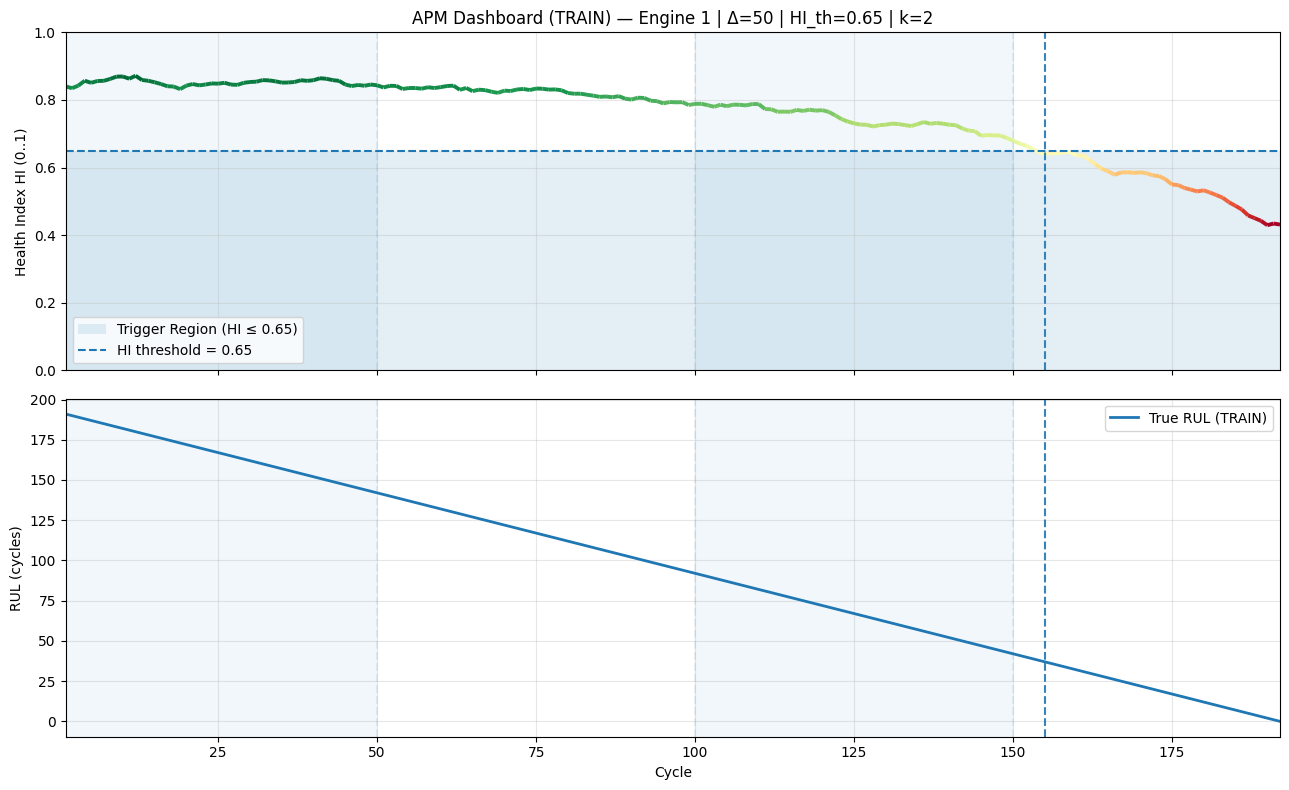

Engine 1 | Outcome: PM (on-time)
  True failure at T_fail = 192 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 155 | True RUL at trigger = 37 cycles
  Inspections: 3 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $90,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,950,000
    Cost rate        = $12,580.65 per cycle



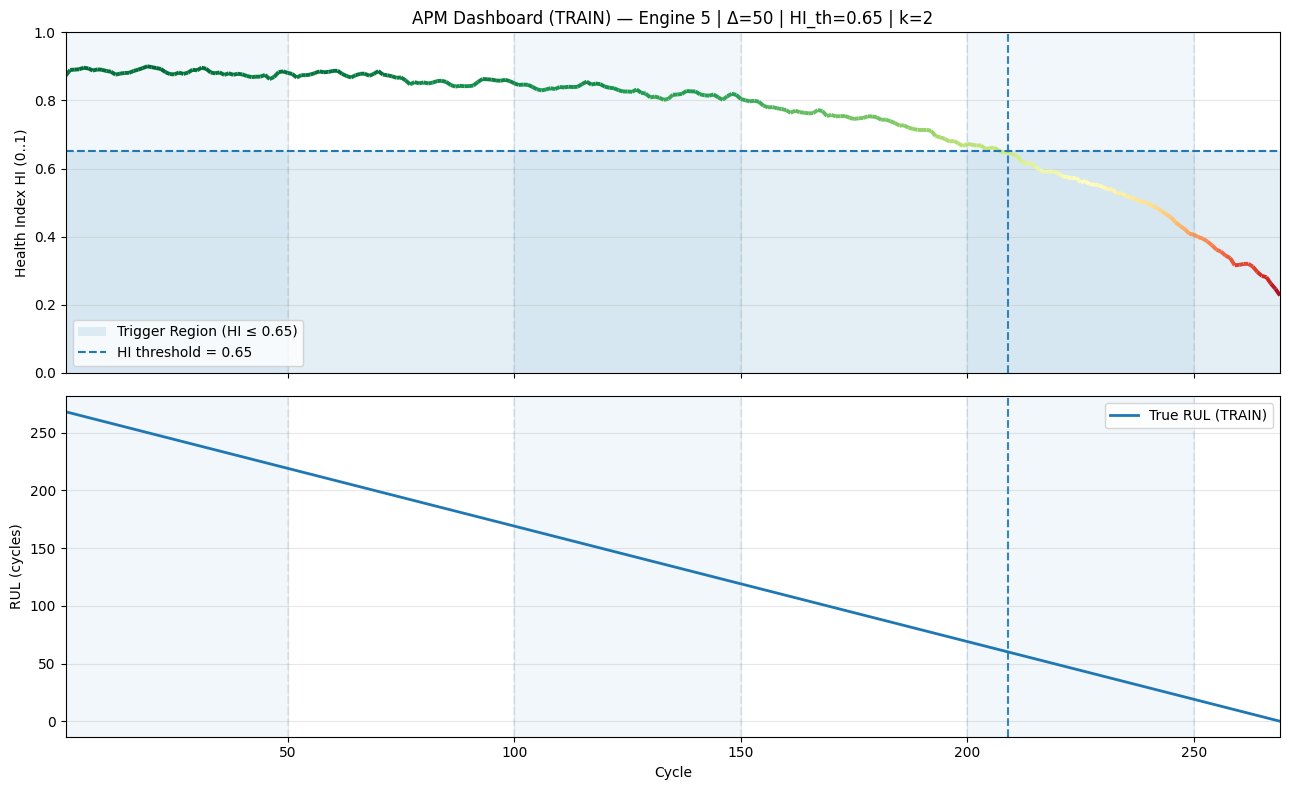

Engine 5 | Outcome: PM (on-time)
  True failure at T_fail = 269 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 209 | True RUL at trigger = 60 cycles
  Inspections: 5 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $150,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $2,010,000
    Cost rate        = $9,617.22 per cycle



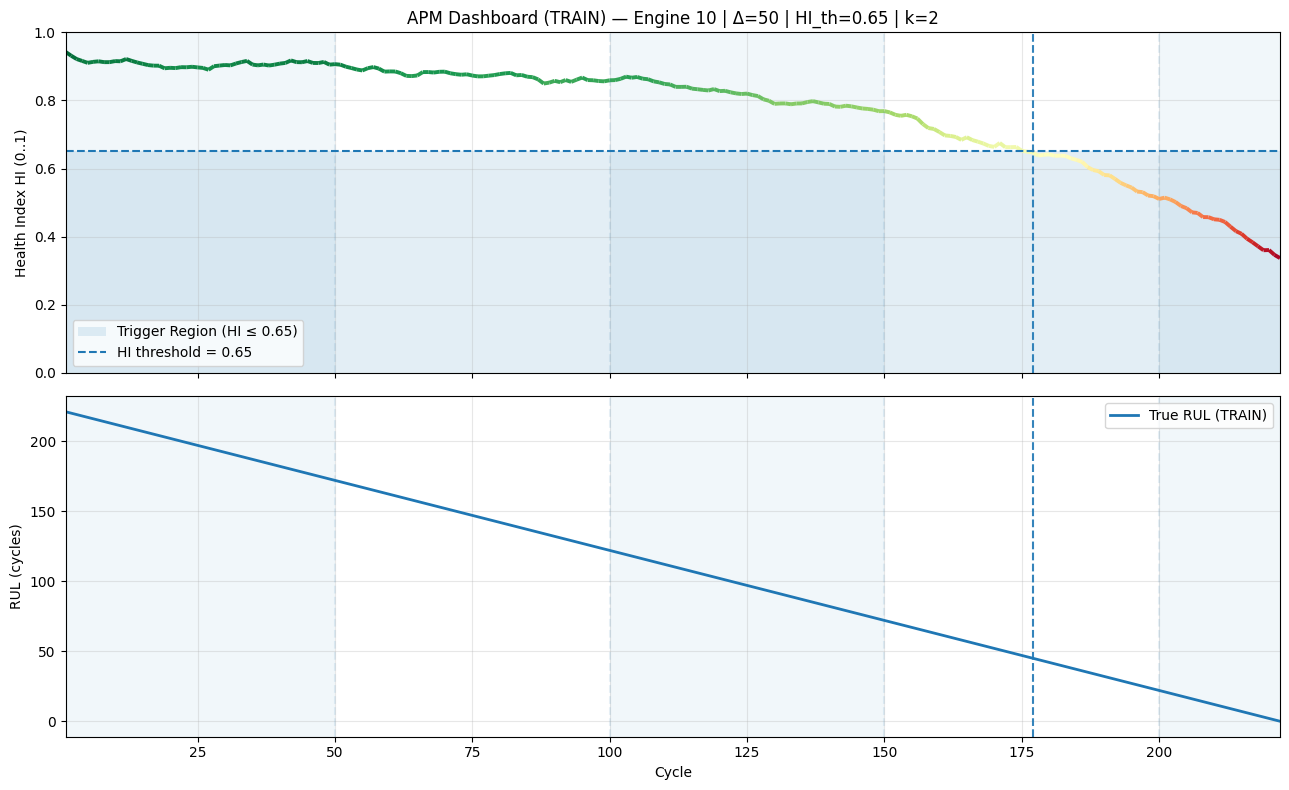

Engine 10 | Outcome: PM (on-time)
  True failure at T_fail = 222 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 177 | True RUL at trigger = 45 cycles
  Inspections: 4 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $120,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,980,000
    Cost rate        = $11,186.44 per cycle



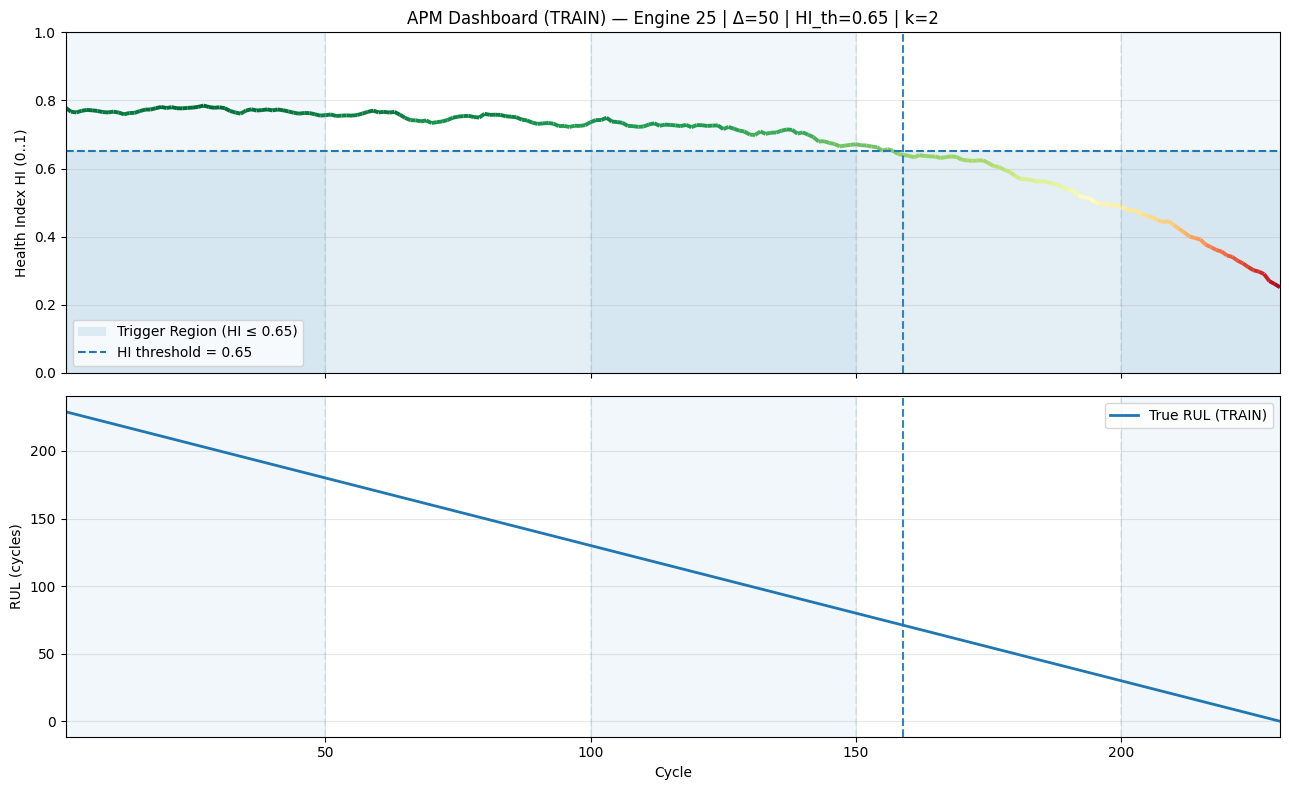

Engine 25 | Outcome: PM (on-time)
  True failure at T_fail = 230 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 159 | True RUL at trigger = 71 cycles
  Inspections: 4 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $120,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,980,000
    Cost rate        = $12,452.83 per cycle



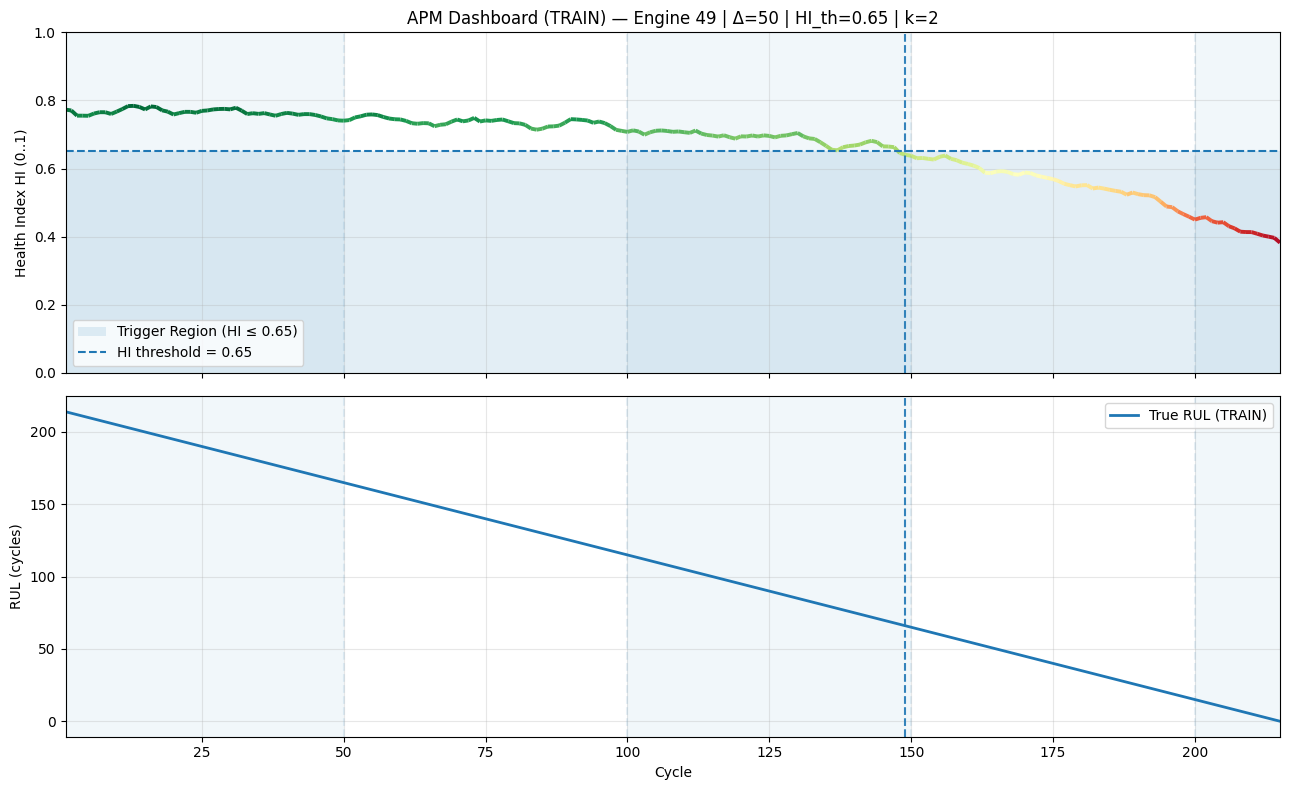

Engine 49 | Outcome: PM (on-time)
  True failure at T_fail = 215 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 149 | True RUL at trigger = 66 cycles
  Inspections: 4 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $120,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,980,000
    Cost rate        = $13,288.59 per cycle



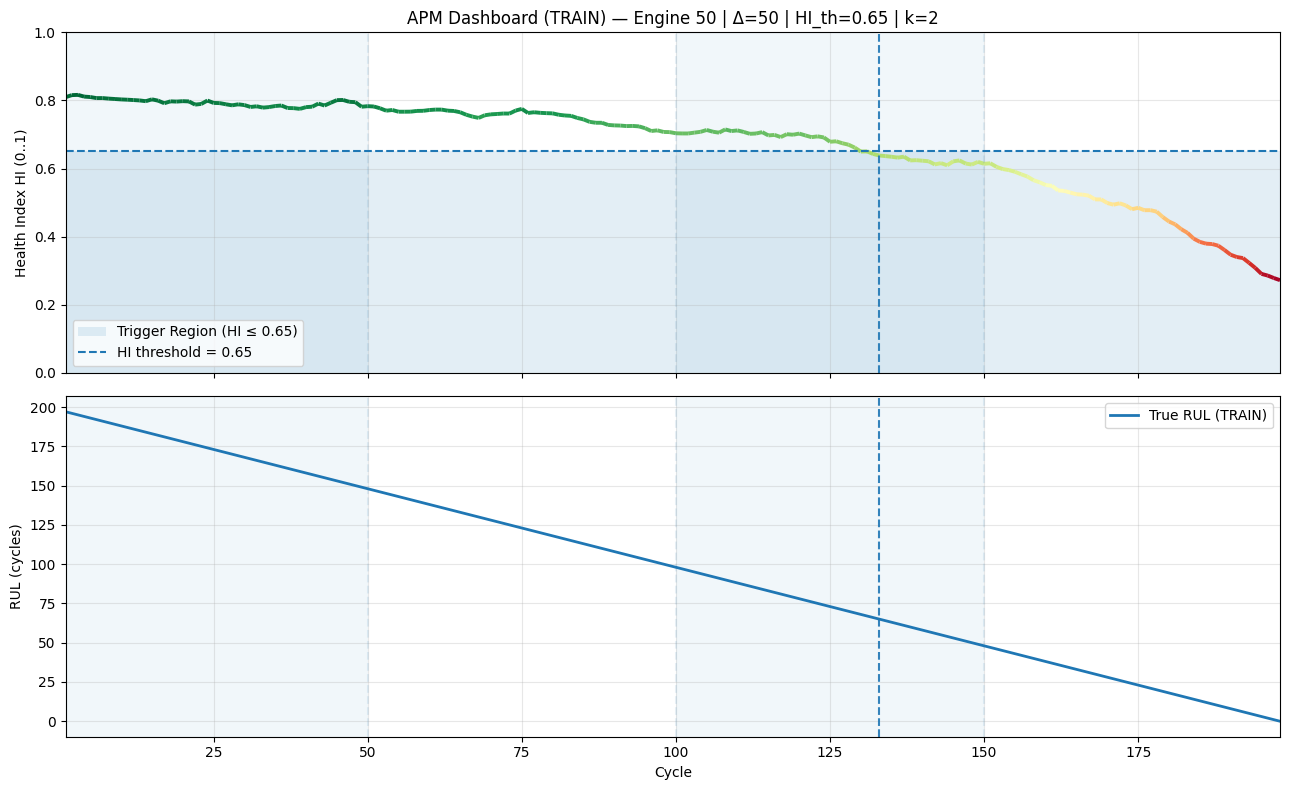

Engine 50 | Outcome: PM (on-time)
  True failure at T_fail = 198 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 133 | True RUL at trigger = 65 cycles
  Inspections: 3 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $90,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,950,000
    Cost rate        = $14,661.65 per cycle



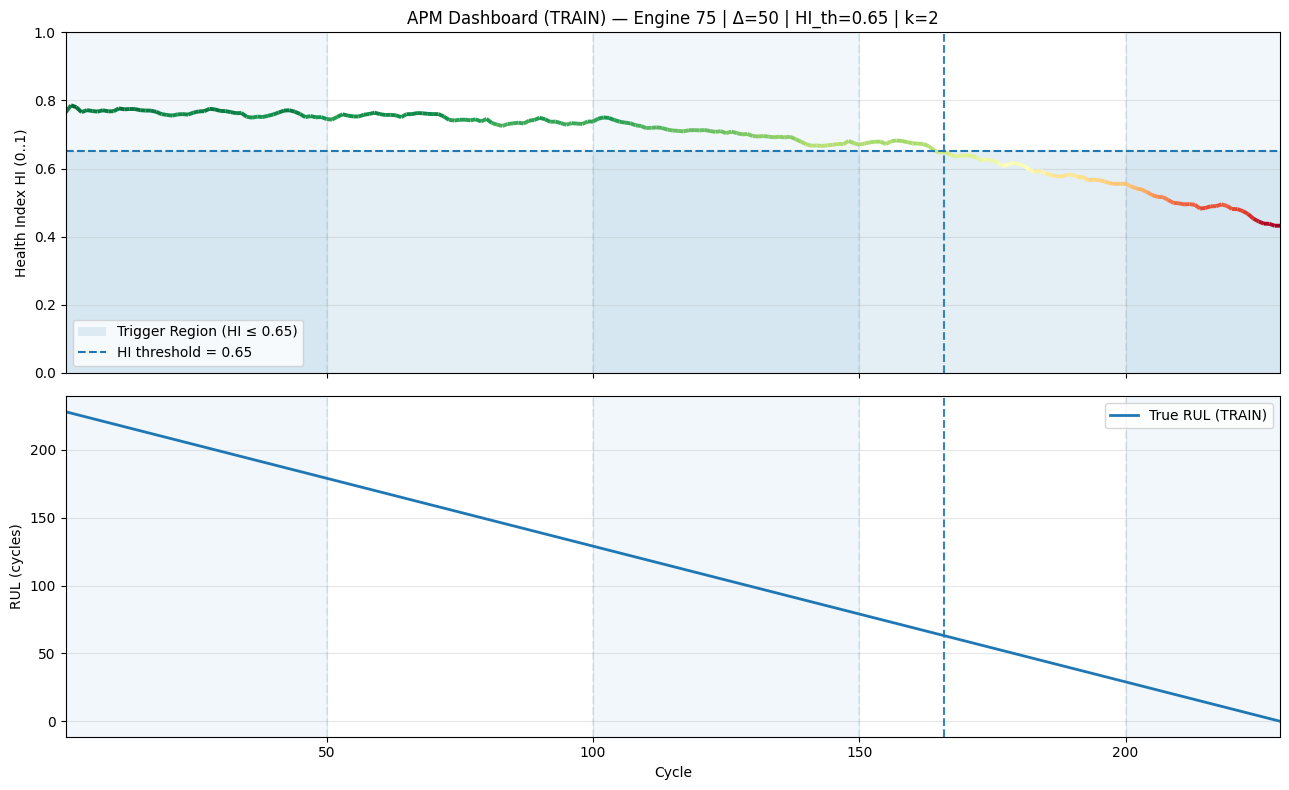

Engine 75 | Outcome: PM (on-time)
  True failure at T_fail = 229 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 166 | True RUL at trigger = 63 cycles
  Inspections: 4 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $120,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,980,000
    Cost rate        = $11,927.71 per cycle



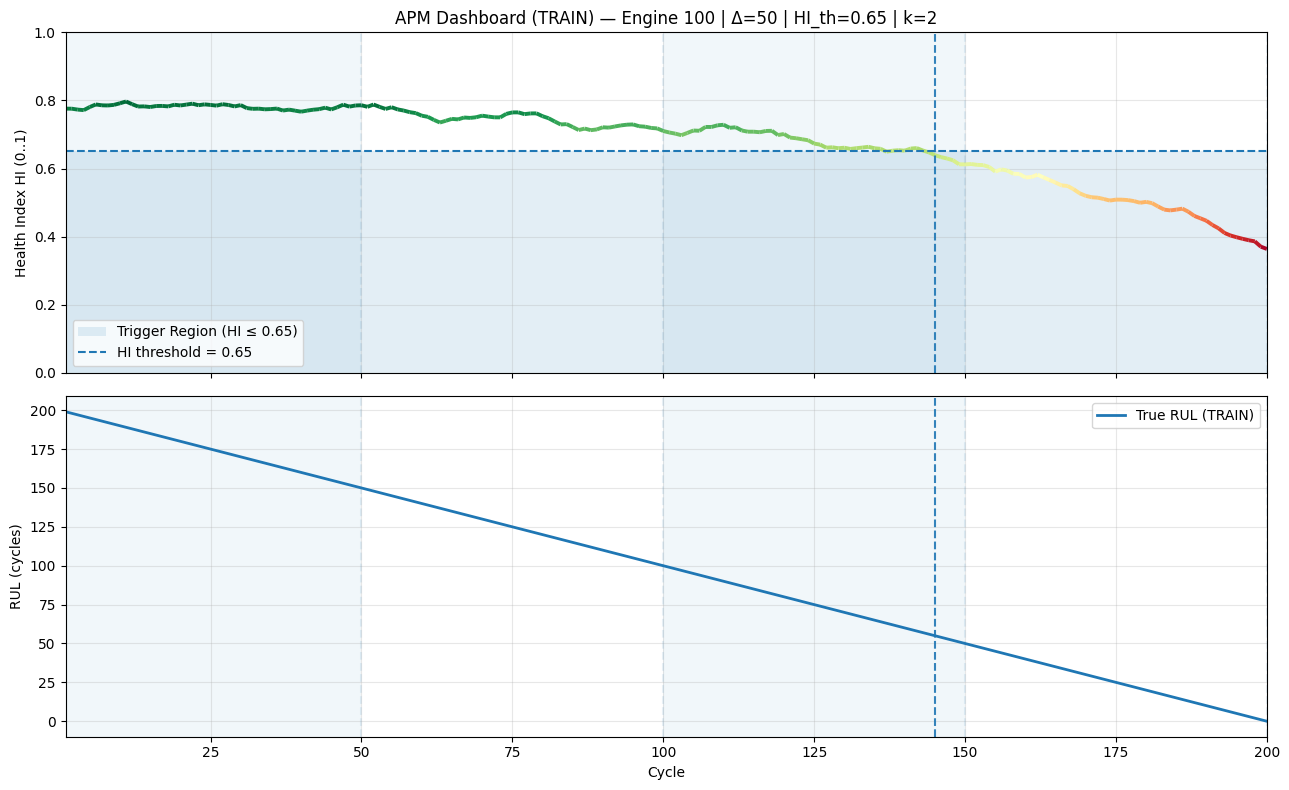

Engine 100 | Outcome: PM (on-time)
  True failure at T_fail = 200 cycles
  Policy: Δ=50, HI_th=0.65, k_confirm=2
  Trigger @ cycle 145 | True RUL at trigger = 55 cycles
  Inspections: 4 | PM: 1 | Failures: 0
  Cost breakdown:
    Inspection cost = $120,000
    PM cost         = $1,860,000
    Failure cost     = $0
    TOTAL cost       = $1,980,000
    Cost rate        = $13,655.17 per cycle



In [28]:
# ========================================================================== #
# FINAL CELL — Fleet APM Dashboard (MULTI-ENGINE) + PER-ENGINE COST          #
#   - Same plotting style as Cell #5 (GREEN→RED gradient HI + RUL panel)     #
#   - Adds per-engine cost breakdown under the chosen (Δ, HI_th, k_confirm)  #
# ========================================================================== #

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import colors as mcolors

# -----------------------------
# Choose engines to plot
# -----------------------------
ENGINES_TO_PLOT = [1, 5, 10, 25, 49, 50, 75, 100]   # <-- edit

# -----------------------------
# Sanity checks
# -----------------------------
if "df_tr" not in globals() or "HI_decision" not in df_tr.columns:
    raise ValueError("df_tr with HI_decision not found. Run Cell #4 first.")
if best_hi_policy is None:
    raise ValueError("best_hi_policy not found. Run Cell #4 first.")
for req in ["engine_id", "cycle", "RUL", "HI_decision"]:
    if req not in df_tr.columns:
        raise ValueError(f"df_tr missing required column: {req}")

# Costs must exist from Cell #0
_ = C_INSPECT, C_PM, C_FAIL, C_DOWNTIME_HR, D_INSPECT_HR, D_PM_HR, D_FAIL_HR, MIN_TRUE_RUL_AT_PM

delta_opt = int(best_hi_policy["delta"])
hi_th_opt = float(best_hi_policy["hi_th"])
k_confirm = int(best_hi_policy["k_confirm"])

# -----------------------------
# Helper: gradient line (green->red by HI value)
# -----------------------------
def plot_gradient_line(ax, x, y, values, linewidth=2.8):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    v = np.asarray(values, float)

    pts = np.array([x, y]).T.reshape(-1, 1, 2)
    segs = np.concatenate([pts[:-1], pts[1:]], axis=1)

    vmin, vmax = float(np.nanmin(v)), float(np.nanmax(v))
    if np.isclose(vmin, vmax):
        norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
    else:
        norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

    lc = LineCollection(segs, cmap="RdYlGn", norm=norm)
    lc.set_array(v[:-1])
    lc.set_linewidth(linewidth)
    ax.add_collection(lc)

    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(min(0.0, np.nanmin(y) - 0.05), max(1.0, np.nanmax(y) + 0.05))
    return lc

# -----------------------------
# Trigger detection (continuous monitoring)
# -----------------------------
def find_trigger_cycle(hi_series, hi_th, k_confirm):
    consec = 0
    for i in range(len(hi_series)):
        if hi_series[i] <= hi_th:
            consec += 1
        else:
            consec = 0
        if consec >= k_confirm:
            return i + 1  # 1-based cycle index
    return None

# -----------------------------
# Per-engine policy simulation + cost breakdown
# -----------------------------
def simulate_engine_cost(d_engine, delta, hi_th, k_confirm):
    """
    Per-engine simulation under continuous monitoring (HI checked every cycle),
    inspection costs charged at multiples of delta.
    Returns a dict with costs, counts, trigger cycle, outcome, etc.
    """
    d = d_engine.sort_values("cycle").reset_index(drop=True)
    cycles = d["cycle"].to_numpy(dtype=int)
    hi_arr = d["HI_decision"].to_numpy(dtype=float)

    T_fail = int(cycles[-1])
    insp_cycles = list(range(delta, T_fail + 1, delta))

    # detect trigger
    trigger_cycle = find_trigger_cycle(hi_arr, hi_th, k_confirm)

    # base inspection cost
    n_insp = len(insp_cycles)
    cost_insp = n_insp * (C_INSPECT + D_INSPECT_HR * C_DOWNTIME_HR)

    # outcome costs
    n_pm = 0
    n_fail = 0
    cost_pm = 0.0
    cost_fail = 0.0
    stop_cycle = T_fail

    if trigger_cycle is None:
        # no trigger -> unplanned failure
        n_fail = 1
        cost_fail = C_FAIL + D_FAIL_HR * C_DOWNTIME_HR
        stop_cycle = T_fail
        outcome = "FAIL (no trigger)"
        true_rul_at_trigger = None
    else:
        true_rul_at_trigger = T_fail - trigger_cycle
        if true_rul_at_trigger <= MIN_TRUE_RUL_AT_PM:
            # late trigger -> treat as failure
            n_fail = 1
            cost_fail = C_FAIL + D_FAIL_HR * C_DOWNTIME_HR
            stop_cycle = T_fail
            outcome = "FAIL (late trigger)"
        else:
            # on-time PM
            n_pm = 1
            cost_pm = C_PM + D_PM_HR * C_DOWNTIME_HR
            stop_cycle = trigger_cycle
            outcome = "PM (on-time)"

    total_cost = cost_insp + cost_pm + cost_fail
    cost_rate = total_cost / max(stop_cycle, 1)

    return {
        "T_fail": T_fail,
        "stop_cycle": stop_cycle,
        "insp_cycles": insp_cycles,
        "n_insp": n_insp,
        "trigger_cycle": trigger_cycle,
        "true_rul_at_trigger": true_rul_at_trigger,
        "outcome": outcome,
        "n_pm": n_pm,
        "n_fail": n_fail,
        "cost_insp": cost_insp,
        "cost_pm": cost_pm,
        "cost_fail": cost_fail,
        "total_cost": total_cost,
        "cost_rate_per_cycle": cost_rate,
    }

# -----------------------------
# Plot dashboards + print costs per engine
# -----------------------------
available_engines = sorted(df_tr["engine_id"].unique().tolist())
missing = [e for e in ENGINES_TO_PLOT if e not in available_engines]
if missing:
    print(f"⚠️ These engines are not found in TRAIN: {missing}\n")

for engine_demo in ENGINES_TO_PLOT:
    d = (df_tr[df_tr["engine_id"] == engine_demo]
         .sort_values("cycle")
         .reset_index(drop=True))

    if d.empty:
        continue

    # Simulate engine under the chosen policy
    sim = simulate_engine_cost(d, delta=delta_opt, hi_th=hi_th_opt, k_confirm=k_confirm)

    cycles = d["cycle"].to_numpy(dtype=int)
    hi_op  = d["HI_decision"].to_numpy(dtype=float)
    rul    = d["RUL"].to_numpy(dtype=float)

    # --- plotting (same layout as Cell #5)
    fig, ax = plt.subplots(2, 1, figsize=(13, 8), sharex=True)
    ax[0].set_title(
        f"APM Dashboard (TRAIN) — Engine {engine_demo} | Δ={delta_opt} | HI_th={hi_th_opt:.2f} | k={k_confirm}"
    )

    # Highlight Δ blocks (alternating)
    blocks = list(range(0, sim["T_fail"] + delta_opt, delta_opt))
    for i in range(len(blocks) - 1):
        x0, x1 = blocks[i], min(blocks[i + 1], sim["T_fail"])
        if i % 2 == 0:
            ax[0].axvspan(x0, x1, alpha=0.06)
            ax[1].axvspan(x0, x1, alpha=0.06)

    # Panel 1: Gradient HI curve
    lc = plot_gradient_line(ax[0], cycles, hi_op, values=hi_op, linewidth=2.8)

    # # Optional colorbar (comment out if you want cleaner slides)
    # cbar = fig.colorbar(lc, ax=ax[0], pad=0.01, fraction=0.03)
    # cbar.set_label("HI level (green=healthy, red=degraded)")

    # Action region + threshold
    ax[0].axhspan(0.0, hi_th_opt, alpha=0.12, label=f"Trigger Region (HI ≤ {hi_th_opt:.2f})")
    ax[0].axhline(hi_th_opt, linestyle="--", label=f"HI threshold = {hi_th_opt:.2f}")

    ax[0].set_ylabel("Health Index HI (0..1)")
    ax[0].grid(True, alpha=0.3)
    ax[0].legend(loc="lower left")

    # Panel 2: True RUL
    ax[1].plot(cycles, rul, linewidth=2, label="True RUL (TRAIN)")
    ax[1].set_xlabel("Cycle")
    ax[1].set_ylabel("RUL (cycles)")
    ax[1].grid(True, alpha=0.3)
    ax[1].legend(loc="upper right")

    # Inspection markers
    for c in sim["insp_cycles"]:
        ax[0].axvline(c, linestyle="--", alpha=0.10)
        ax[1].axvline(c, linestyle="--", alpha=0.10)

    # Trigger marker
    if sim["trigger_cycle"] is not None:
        ax[0].axvline(sim["trigger_cycle"], linestyle="--", alpha=0.9)
        ax[1].axvline(sim["trigger_cycle"], linestyle="--", alpha=0.9)

    plt.tight_layout()
    plt.show()

    # -----------------------------
    # Print per-engine cost summary
    # -----------------------------
    print(f"Engine {engine_demo} | Outcome: {sim['outcome']}")
    print(f"  True failure at T_fail = {sim['T_fail']} cycles")
    print(f"  Policy: Δ={delta_opt}, HI_th={hi_th_opt:.2f}, k_confirm={k_confirm}")

    if sim["trigger_cycle"] is None:
        print("  Trigger: None")
    else:
        print(f"  Trigger @ cycle {sim['trigger_cycle']} | True RUL at trigger = {sim['true_rul_at_trigger']} cycles")

    print(f"  Inspections: {sim['n_insp']} | PM: {sim['n_pm']} | Failures: {sim['n_fail']}")
    print("  Cost breakdown:")
    print(f"    Inspection cost = ${sim['cost_insp']:,.0f}")
    print(f"    PM cost         = ${sim['cost_pm']:,.0f}")
    print(f"    Failure cost     = ${sim['cost_fail']:,.0f}")
    print(f"    TOTAL cost       = ${sim['total_cost']:,.0f}")
    print(f"    Cost rate        = ${sim['cost_rate_per_cycle']:,.2f} per cycle\n")


## 🧾 HI-Policy Classification Report (Confusion Matrix + Accuracy/Precision/Recall) ✅📊

This cell evaluates the **HI-threshold maintenance rule** as a **binary classifier** on FD001 TRAIN data.

### 🔍 How the labels are defined
- **Actual (y_true):** an engine-cycle is labeled **“At-risk” = 1** if  
  ✅ `RUL ≤ TAU_ALARM` (within the next *TAU_ALARM* cycles to failure).  
- **Predicted (y_pred):** an **alarm = 1** is raised if  
  🚨 `HI_decision ≤ HI_th` for **k_confirm** consecutive cycles.

### ⚙️ What the cell outputs
- **Confusion Matrix:** TN / FP / FN / TP (per-cycle)  
- **Performance metrics:**  
  - Accuracy ✅  
  - Precision 🎯  
  - Recall (Sensitivity) 📌  
  - Specificity 🛡️  
  - F1-score ⚖️  
  - Balanced Accuracy ⚖️

### ✅ Why this is useful
It quantifies how well the optimized HI policy detects **near-failure conditions** (early warnings) versus producing **false alarms**, which directly connects to **cost, downtime, and safety trade-offs** in APM/CBM decisions 🏭💰⏱️


In [ ]:
# =========================
# ISE-510 — Classification Metrics for HI Policy (Confusion Matrix + Acc/Prec/Recall/F1) ✅
# Interprets the HI-threshold rule as an "alarm" classifier:
#   y_true = 1 if engine is within TAU_ALARM cycles of failure (i.e., RUL <= TAU_ALARM)
#   y_pred = 1 if HI_decision goes below HI_th with k_confirm consecutive cycles
# =========================

from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    balanced_accuracy_score
)

# -----------------------------
# Sanity checks
# -----------------------------
if "df_tr" not in globals() or "HI_decision" not in df_tr.columns:
    raise ValueError("df_tr with HI_decision not found. Run ISE-510 Cell #4 first.")
if best_hi_policy is None:
    raise ValueError("best_hi_policy not found. Run ISE-510 Cell #4 first.")
for col in ["engine_id", "cycle", "RUL", "HI_decision"]:
    if col not in df_tr.columns:
        raise ValueError(f"df_tr missing required column: {col}")

hi_th_opt = float(best_hi_policy["hi_th"])
k_confirm = int(best_hi_policy["k_confirm"])

# -----------------------------
# Choose what "positive class" means (edit if you want)
# -----------------------------
# Positive = "at-risk / needs action soon" (within TAU_ALARM cycles to failure)
TAU_ALARM = int(globals().get("TAU_ALARM", 50))  # e.g., 20, 30, 50 ...

df_eval = df_tr.sort_values(["engine_id", "cycle"]).copy()

# Ground-truth label per cycle (based on true RUL)
y_true = (df_eval["RUL"].to_numpy(dtype=float) <= TAU_ALARM).astype(int)

# Predicted alarm based on HI_decision threshold
below = (df_eval["HI_decision"].to_numpy(dtype=float) <= hi_th_opt)

def consecutive_true_flags(bool_arr):
    """Return array of consecutive-True counts (run length)."""
    out = np.zeros(len(bool_arr), dtype=int)
    c = 0
    for i, v in enumerate(bool_arr):
        c = c + 1 if v else 0
        out[i] = c
    return out

# apply k_confirm per engine
consec = (
    df_eval.groupby("engine_id")["HI_decision"]
          .apply(lambda s: consecutive_true_flags((s.to_numpy(float) <= hi_th_opt)))
          .explode()
          .astype(int)
          .to_numpy()
)

y_pred = (consec >= k_confirm).astype(int)

# -----------------------------
# Confusion matrix + metrics
# -----------------------------
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, zero_division=0)
rec  = recall_score(y_true, y_pred, zero_division=0)
f1   = f1_score(y_true, y_pred, zero_division=0)
bacc = balanced_accuracy_score(y_true, y_pred)

# Specificity (TNR)
spec = tn / (tn + fp) if (tn + fp) > 0 else 0.0

cm_df = pd.DataFrame(
    cm,
    index=["Actual 0 (Not at-risk)", "Actual 1 (At-risk)"],
    columns=["Pred 0 (No alarm)", "Pred 1 (Alarm)"]
)

metrics_df = pd.DataFrame(
    {
        "TAU_ALARM (cycles)": [TAU_ALARM],
        "HI_th": [hi_th_opt],
        "k_confirm": [k_confirm],
        "Accuracy": [acc],
        "Balanced_Accuracy": [bacc],
        "Precision": [prec],
        "Recall (TPR)": [rec],
        "Specificity (TNR)": [spec],
        "F1": [f1],
        "TP": [tp], "FP": [fp], "TN": [tn], "FN": [fn],
        "Positive_rate (Actual)": [float(y_true.mean())],
        "Alarm_rate (Pred)": [float(y_pred.mean())],
    }
)

print("Confusion Matrix (per-cycle evaluation):")
display(cm_df)

print("\nMetrics:")
display(metrics_df.style.format({c: "{:.4f}" for c in metrics_df.columns if c not in ["TAU_ALARM (cycles)", "k_confirm", "TP","FP","TN","FN"]}))


Confusion Matrix (per-cycle evaluation):


,Pred 0 (No alarm),Pred 1 (Alarm)
Actual 0 (Not at-risk),14369,1162
Actual 1 (At-risk),547,4553



Metrics:


,TAU_ALARM (cycles),HI_th,k_confirm,Accuracy,Balanced_Accuracy,Precision,Recall (TPR),Specificity (TNR),F1,TP,FP,TN,FN,Positive_rate (Actual),Alarm_rate (Pred)
0,50,0.6500,2,0.9172,0.9090,0.7967,0.8927,0.9252,0.8420,4553,1162,14369,547,0.2472,0.2770


# ✅ Final Summary & Conclusion (ISE-506 + ISE-510) 🏁📌

## 🔹 ISE-506 (Advanced Reliability Engineering) — What We Actually Did 🧪📈
Using **FD001 TRAIN as run-to-failure life data**, we built a full **fleet reliability model** and applied it to the TEST fleet.

### 1️⃣ Fleet lifetime extraction (TRAIN) ⏳✅
- Computed **cycles-to-failure** per engine: `life = max(cycle)` for each `engine_id`.

### 2️⃣ Parametric reliability model (Weibull) 📌📉
- Fit a **2-parameter Weibull** (`loc=0`) → estimated **β (shape)** and **η (scale)**.
- Computed **MTTF** from Weibull parameters 🧮.

### 3️⃣ Nonparametric benchmark (Kaplan–Meier) 🪜📊
- Built **KM survival** as an empirical benchmark for the fleet reliability.

### 4️⃣ Fit validation (visual + numeric) 🔍✅
- Plotted **KM vs Weibull** to visually verify the model fit.
- Computed GOF metrics:
  - **KS D** (max CDF mismatch)
  - **RMSE in reliability** (average survival mismatch)

### 5️⃣ Apply Weibull to TEST fleet (age-based risk) 🧑‍🏭⚙️
For each TEST engine:
- Extracted current age `t_current = max(cycle)`
- Computed:
  - **R(t_current)**  
  - **R(τ | t_current)**  
  - **P(fail in next τ) = 1 − R(τ | t_current)** 🚨
- Plotted **conditional reliability curves** for all TEST engines colored by current age 🎨📉

✅ **Bottom line (ISE-506):** A validated **fleet Weibull reliability model** + **engine-specific conditional risk forecasting**.

---

## 🔹 ISE-510 (Maintenance Systems Management) — What We Actually Did 🏭⚙️
Using FD001 sensor data, we built **health monitoring + RUL prediction**, then optimized a **CBM policy** under **cost + downtime + safety**.

### 0️⃣ Define decision framework (costs + safety rules) 💰🛡️
- Set maintenance economics:
  - `C_INSPECT`, `C_PM`, `C_FAIL` + downtime penalty ⏱️💸
- Set constraints/rules:
  - **Max unplanned fail rate** `MAX_UNPLANNED_FAIL_RATE`
  - **Late PM rule**: PM considered too late if true RUL at trigger ≤ `MIN_TRUE_RUL_AT_PM` ⚠️

### 1️⃣ Build explainable Health Index (HI) from original features 🧠📈
- Used **Ridge regression** on standardized sensors (no PCA) ✅
- Selected Ridge alpha via **GroupKFold(engine_id)** to avoid leakage 🚫
- Converted predicted capped-RUL → **HI in [0,1]** (higher = healthier) 🎚️
- Reported correlation and top weighted features (interpretability) 🔍

### 2️⃣ Train Deep RUL model (LSTM→GRU) for temporal degradation 🤖⏳
- Built windowed sequences (`WINDOW`, `STRIDE`) 🪟
- Trained LSTM→GRU using **GroupKFold(engine-wise)** (no leakage) ✅
- Reported OOF errors (RMSE/MAE) and last-window RMSE 🎯
- Saved trained ensemble models as `final_models` ✅

### 3️⃣ Deploy deep predictions as cycle-by-cycle signals 🔁📊
- Generated `RUL_pred_DL` for every cycle (ffill/bfill within engine) ✅
- Normalized deep RUL → `HI_pred` on a 0–1 HI scale 🎚️  
  *(kept for comparison and future extensions)*

### 4️⃣ Optimize CBM policy using operational HI signal 🧾⚙️
- Defined the **decision HI** as smoothed empirical HI:
  - `HI_decision = rolling_mean(HI)` ✨
- Simulated a **continuous monitoring policy**:
  - check HI every cycle 🔄
  - trigger PM when `HI_decision ≤ HI_th` for `k_confirm` cycles 🚨
  - charge inspection costs only at `Δ, 2Δ, ...` 🗓️
  - treat late triggers as failures if RUL buffer violated ⚠️
- Performed grid search over `(Δ, HI_th, k_confirm)`:
  - enforced **fail_rate ≤ MAX_UNPLANNED_FAIL_RATE** 🛡️
  - minimized **cost rate per cycle** 💰📉
- Output: `best_hi_policy` ✅

### 5️⃣ Fleet APM dashboard + per-engine cost impact 🏭🟢➡️🔴💵
- Plotted multiple engines with:
  - **green→red HI degradation curve** (intuitive dashboard view)
  - threshold/action region + inspection intervals + trigger marker ✅
  - true RUL panel for context 📉
- Printed per-engine:
  - outcome (PM / fail late / fail no trigger)
  - inspections, PM, failures
  - cost breakdown (inspection + PM + failure) and cost rate 💵

✅ **Bottom line (ISE-510):** A complete pipeline from **sensor HI/RUL → CBM trigger rule → cost-optimized policy → fleet dashboard + per-engine economics**, under safety constraints.

---

## 🔥 Integrated Conclusion (506 + 510) — One Story 🧩🏆
- **ISE-506** gives **age-based risk**: *R(t), R(τ|t), probability of failure* 📈🛡️  
- **ISE-510** gives **action-based decisions**: *when to inspect/maintain to minimize cost while staying safe* ⚙️💰✅

🎯 **Final takeaway:**  
Together, the project links **reliability modeling (Weibull + KM + conditional survival)** ➜ with **maintenance optimization (HI monitoring + economic/safety constraints)**, forming a full engineering workflow from **age → risk → monitoring → decision → cost impact** ✅📊⚙️
